In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from itertools import product
from collections import defaultdict
import shap

In [167]:
from sklearn.base import clone
from copy import deepcopy

In [3]:
from sklearn.metrics import roc_auc_score

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit
kf = StratifiedShuffleSplit(n_splits=5)

In [10]:
series = pd.read_csv('train.csv')
series.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.0,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.0,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.0,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.0,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.0,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359


In [7]:
labels = pd.read_csv('train_labels.csv', index_col=['sequence'])
labels.head()

,state
sequence,
0,0
1,1
2,1
3,1
4,1


some ideas from https://www.kaggle.com/code/dmitryuarov/tps-sensors-2xlstm-xgb-auc-0-976#XGB

In [57]:
tmp = series.groupby('sequence').agg({'sensor_00':['mean','std']})
tmp.reset_index()

sequence sensor_00          
                    mean       std
0            0  0.041744  1.431660
1            1 -0.069294  1.593907
2            2 -0.001546  1.147526
3            3  0.029869  1.769705
4            4  0.059132  2.014779
...        ...       ...       ...
25963    25963  0.100773  1.547826
25964    25964  0.017182  1.054727
25965    25965 -0.006466  1.227428
25966    25966 -0.040417  0.885836
25967    25967 -0.011850  0.729595

[25968 rows x 3 columns]

In [17]:
tmp.columns.map('_'.join)

Index(['sensor_00_mean', 'sensor_00_std'], dtype='object')

In [28]:
pd.merge?

In [54]:
series.columns[3:]

Index(['sensor_00', 'sensor_01', 'sensor_02', 'sensor_03', 'sensor_04',
       'sensor_05', 'sensor_06', 'sensor_07', 'sensor_08', 'sensor_09',
       'sensor_10', 'sensor_11', 'sensor_12'],
      dtype='object')

In [58]:
np.quantile?

quantile needs a decoration: https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function

In [104]:
def quantile(q):
    def quantile_(x):
        return np.quantile(x,q)
    quantile_.__name__ = f"quantile_{str(q)}"
    return quantile_

In [115]:
def prep(df):
    result = pd.DataFrame()
    result['sequence'] = df['sequence'].unique()
    result = result.merge(df[['sequence','subject']], how='left',on='sequence')
    
    for sensor in df.columns[3:]:
        print(f"doing {sensor}")
        aggs = df.groupby('sequence').agg({sensor:['mean','std','median','mad',
                                                      'min','max','sum','skew',
                                                   quantile(0.1), quantile(0.9)]})
        aggs.columns = aggs.columns.map('_'.join)
        result = result.merge(aggs.reset_index(),how='left',on='sequence')
        print(result.columns)

    for sensor in df.columns[3:]:
        print(f"doing {sensor}")
        aggs = df.groupby('subject').agg({sensor:['mean','std','median','mad',
                                                      'min','max','sum','skew',
                                                   quantile(0.1), quantile(0.9)]})
        aggs.columns = aggs.columns.map('_subject_'.join)
        result = result.merge(aggs.reset_index(),how='left',on='subject')
        print(result.columns)
    
    
    result = result.drop_duplicates()
    result.index = np.arange(len(result))
    return result

In [116]:
train = prep(series)

doing sensor_00
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew', 'sensor_00_quantile_0.1',
       'sensor_00_quantile_0.9'],
      dtype='object')
doing sensor_01
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew', 'sensor_00_quantile_0.1',
       'sensor_00_quantile_0.9', 'sensor_01_mean', 'sensor_01_std',
       'sensor_01_median', 'sensor_01_mad', 'sensor_01_min', 'sensor_01_max',
       'sensor_01_sum', 'sensor_01_skew', 'sensor_01_quantile_0.1',
       'sensor_01_quantile_0.9'],
      dtype='object')
doing sensor_02
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew', 'sensor_00_quantile

Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew', 'sensor_00_quantile_0.1',
       'sensor_00_quantile_0.9', 'sensor_01_mean', 'sensor_01_std',
       'sensor_01_median', 'sensor_01_mad', 'sensor_01_min', 'sensor_01_max',
       'sensor_01_sum', 'sensor_01_skew', 'sensor_01_quantile_0.1',
       'sensor_01_quantile_0.9', 'sensor_02_mean', 'sensor_02_std',
       'sensor_02_median', 'sensor_02_mad', 'sensor_02_min', 'sensor_02_max',
       'sensor_02_sum', 'sensor_02_skew', 'sensor_02_quantile_0.1',
       'sensor_02_quantile_0.9', 'sensor_03_mean', 'sensor_03_std',
       'sensor_03_median', 'sensor_03_mad', 'sensor_03_min', 'sensor_03_max',
       'sensor_03_sum', 'sensor_03_skew', 'sensor_03_quantile_0.1',
       'sensor_03_quantile_0.9', 'sensor_04_mean', 'sensor_04_std',
       'sensor_04_median', 'sensor_04_mad', 'sensor_04_min', 'sensor_04_max',
 

Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew',
       ...
       'sensor_08_subject_mean', 'sensor_08_subject_std',
       'sensor_08_subject_median', 'sensor_08_subject_mad',
       'sensor_08_subject_min', 'sensor_08_subject_max',
       'sensor_08_subject_sum', 'sensor_08_subject_skew',
       'sensor_08_subject_quantile_0.1', 'sensor_08_subject_quantile_0.9'],
      dtype='object', length=222)
doing sensor_09
Index(['sequence', 'subject', 'sensor_00_mean', 'sensor_00_std',
       'sensor_00_median', 'sensor_00_mad', 'sensor_00_min', 'sensor_00_max',
       'sensor_00_sum', 'sensor_00_skew',
       ...
       'sensor_09_subject_mean', 'sensor_09_subject_std',
       'sensor_09_subject_median', 'sensor_09_subject_mad',
       'sensor_09_subject_min', 'sensor_09_subject_max',
       'sensor_09_subject_sum', 'sensor_09_subject_skew',
       'sensor_0

In [119]:
train.head()

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_12_subject_std,sensor_12_subject_median,sensor_12_subject_mad,sensor_12_subject_min,sensor_12_subject_max,sensor_12_subject_sum,sensor_12_subject_skew,sensor_12_subject_quantile_0.1,sensor_12_subject_quantile_0.9,label
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,20.293662,-0.254476,12.579934,-312.621910,213.832481,-491.551151,-0.709353,-18.520588,19.573359,0
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,46.380511,-0.006181,21.210487,-317.453112,268.698210,-1189.222933,-0.249052,-41.808824,36.950000,1
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,46.380511,-0.006181,21.210487,-317.453112,268.698210,-1189.222933,-0.249052,-41.808824,36.950000,1
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,0.533071,-0.012788,0.349181,-3.136829,3.487639,6.289855,0.321107,-0.538107,0.558227,1
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0.318285,0.003410,0.216635,-2.805200,2.629156,3.347826,-0.224039,-0.394288,0.387937,1


In [118]:
train['label'] = labels['state']

### do some EDA to see if anything pops out

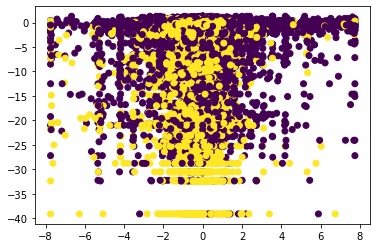

In [137]:
plt.scatter(train['sensor_02_skew'].values, train['sensor_02_subject_skew'].values,c=train['label'])

### do a brute force xgboost

In [138]:
X, y = train.drop(columns=['sequence','subject','label']).values, train['label'].values

In [139]:
X.shape, y.shape

((25968, 260), (25968,))

In [182]:
def gridsearch_xgboost(params, X, y, obj="binary:logistic"):
    ''' the params include both the fit and the booster params '''
    
    param_names, param_vals = zip(*list(params.items()))
    id_booster, id_fit = [], []
    for idx, name in enumerate(param_names):
        if (name=='early_stopping_rounds'):
            id_fit.append(idx)
        else:
            id_booster.append(idx)
    
    best_test_score = 0.0
    for val_combination in product(*param_vals):
        param_fit, param_booster = {}, {}
        param_fit['eval_metric'] = 'auc'
        for idx in id_fit:
            param_fit[param_names[idx]] = val_combination[idx]
        for idx in id_booster:
            param_booster[param_names[idx]] = val_combination[idx]
        print(f"param_fit: {param_fit}")
        print(f"param_booster: {param_booster}")
        
        clf = XGBClassifier(**param_booster, objective=obj, use_label_encoder=False)
        result = defaultdict(list)
        for train_idx, test_idx in kf.split(X, y):
            X_train, y_train = X[train_idx], y[train_idx]
            X_test, y_test = X[test_idx], y[test_idx]
            param_fit['eval_set'] = [(X_test, y_test)]            
            clf.fit(X_train, y_train, **param_fit, verbose=True)
            if hasattr(clf, 'best_ntree_limit'):
                result['ntree'].append(clf.best_ntree_limit)
            else:
                result['ntree'].append(clf.n_estimators)            
            result['score'].append(roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
            print(f'stop at {result["ntree"][-1]}, score={result["score"][-1]}')

        mean_test_score = np.mean(result['score'])
        print(f"mean_test_score={mean_test_score}")
        if mean_test_score > best_test_score:
            best_test_score = mean_test_score
            best_param_booster = param_booster
            best_param_booster['n_estimators'] = np.int32(np.mean(result['ntree']))
            dum_clf = deepcopy(clf)
    
    return best_param_booster, dum_clf

In [185]:
params = {'gamma': [0],
          'max_depth': [6],
          'min_child_weight': [0.0],
          'n_estimators': [10000],
          'early_stopping_rounds': [50],
          'learning_rate': [0.3]}

In [186]:
best_param_booster, dum_clf = gridsearch_xgboost(params, X, y)

param_fit: {'eval_metric': 'auc', 'early_stopping_rounds': 50}
param_booster: {'gamma': 0, 'max_depth': 6, 'min_child_weight': 0.0, 'n_estimators': 10000, 'learning_rate': 0.3}
[0]	validation_0-auc:0.79859
[1]	validation_0-auc:0.82523
[2]	validation_0-auc:0.83128
[3]	validation_0-auc:0.84732
[4]	validation_0-auc:0.85497
[5]	validation_0-auc:0.85966
[6]	validation_0-auc:0.86777
[7]	validation_0-auc:0.87340
[8]	validation_0-auc:0.87632
[9]	validation_0-auc:0.88310
[10]	validation_0-auc:0.88665
[11]	validation_0-auc:0.89028
[12]	validation_0-auc:0.89378
[13]	validation_0-auc:0.89541
[14]	validation_0-auc:0.89600
[15]	validation_0-auc:0.89841
[16]	validation_0-auc:0.89981
[17]	validation_0-auc:0.90169
[18]	validation_0-auc:0.90344
[19]	validation_0-auc:0.90398
[20]	validation_0-auc:0.90634
[21]	validation_0-auc:0.90831
[22]	validation_0-auc:0.90976
[23]	validation_0-auc:0.91124
[24]	validation_0-auc:0.91217
[25]	validation_0-auc:0.91336
[26]	validation_0-auc:0.91465
[27]	validation_0-auc:0

[263]	validation_0-auc:0.93701
[264]	validation_0-auc:0.93701
[265]	validation_0-auc:0.93705
[266]	validation_0-auc:0.93725
[267]	validation_0-auc:0.93722
[268]	validation_0-auc:0.93719
[269]	validation_0-auc:0.93737
[270]	validation_0-auc:0.93731
[271]	validation_0-auc:0.93743
[272]	validation_0-auc:0.93732
[273]	validation_0-auc:0.93716
[274]	validation_0-auc:0.93717
[275]	validation_0-auc:0.93716
[276]	validation_0-auc:0.93711
[277]	validation_0-auc:0.93710
[278]	validation_0-auc:0.93707
[279]	validation_0-auc:0.93710
[280]	validation_0-auc:0.93711
[281]	validation_0-auc:0.93710
[282]	validation_0-auc:0.93706
[283]	validation_0-auc:0.93713
[284]	validation_0-auc:0.93716
[285]	validation_0-auc:0.93709
[286]	validation_0-auc:0.93717
[287]	validation_0-auc:0.93716
[288]	validation_0-auc:0.93735
[289]	validation_0-auc:0.93731
[290]	validation_0-auc:0.93733
[291]	validation_0-auc:0.93720
[292]	validation_0-auc:0.93731
[293]	validation_0-auc:0.93722
[294]	validation_0-auc:0.93722
[295]	va

[528]	validation_0-auc:0.94083
[529]	validation_0-auc:0.94084
[530]	validation_0-auc:0.94084
[531]	validation_0-auc:0.94087
[532]	validation_0-auc:0.94084
[533]	validation_0-auc:0.94085
[534]	validation_0-auc:0.94083
[535]	validation_0-auc:0.94086
[536]	validation_0-auc:0.94086
[537]	validation_0-auc:0.94079
[538]	validation_0-auc:0.94080
[539]	validation_0-auc:0.94073
[540]	validation_0-auc:0.94068
[541]	validation_0-auc:0.94070
[542]	validation_0-auc:0.94082
[543]	validation_0-auc:0.94086
[544]	validation_0-auc:0.94080
[545]	validation_0-auc:0.94086
[546]	validation_0-auc:0.94091
[547]	validation_0-auc:0.94096
[548]	validation_0-auc:0.94092
[549]	validation_0-auc:0.94100
[550]	validation_0-auc:0.94097
[551]	validation_0-auc:0.94094
[552]	validation_0-auc:0.94097
[553]	validation_0-auc:0.94096
[554]	validation_0-auc:0.94102
[555]	validation_0-auc:0.94101
[556]	validation_0-auc:0.94098
[557]	validation_0-auc:0.94093
[558]	validation_0-auc:0.94092
[559]	validation_0-auc:0.94094
[560]	va

[793]	validation_0-auc:0.94227
[794]	validation_0-auc:0.94229
[795]	validation_0-auc:0.94228
[796]	validation_0-auc:0.94227
[797]	validation_0-auc:0.94230
[798]	validation_0-auc:0.94232
[799]	validation_0-auc:0.94235
[800]	validation_0-auc:0.94231
[801]	validation_0-auc:0.94230
[802]	validation_0-auc:0.94231
[803]	validation_0-auc:0.94235
[804]	validation_0-auc:0.94234
[805]	validation_0-auc:0.94234
[806]	validation_0-auc:0.94238
[807]	validation_0-auc:0.94236
[808]	validation_0-auc:0.94235
[809]	validation_0-auc:0.94238
[810]	validation_0-auc:0.94237
[811]	validation_0-auc:0.94238
[812]	validation_0-auc:0.94240
[813]	validation_0-auc:0.94244
[814]	validation_0-auc:0.94247
[815]	validation_0-auc:0.94249
[816]	validation_0-auc:0.94248
[817]	validation_0-auc:0.94245
[818]	validation_0-auc:0.94243
[819]	validation_0-auc:0.94243
[820]	validation_0-auc:0.94247
[821]	validation_0-auc:0.94249
[822]	validation_0-auc:0.94250
[823]	validation_0-auc:0.94252
[824]	validation_0-auc:0.94249
[825]	va

[1056]	validation_0-auc:0.94328
[1057]	validation_0-auc:0.94326
[1058]	validation_0-auc:0.94326
[1059]	validation_0-auc:0.94323
[1060]	validation_0-auc:0.94325
[1061]	validation_0-auc:0.94327
[1062]	validation_0-auc:0.94327
[1063]	validation_0-auc:0.94327
[1064]	validation_0-auc:0.94325
[1065]	validation_0-auc:0.94324
[1066]	validation_0-auc:0.94325
[1067]	validation_0-auc:0.94325
[1068]	validation_0-auc:0.94326
[1069]	validation_0-auc:0.94326
[1070]	validation_0-auc:0.94325
[1071]	validation_0-auc:0.94325
[1072]	validation_0-auc:0.94324
[1073]	validation_0-auc:0.94325
[1074]	validation_0-auc:0.94325
[1075]	validation_0-auc:0.94324
[1076]	validation_0-auc:0.94324
[1077]	validation_0-auc:0.94322
[1078]	validation_0-auc:0.94320
[1079]	validation_0-auc:0.94319
[1080]	validation_0-auc:0.94318
[1081]	validation_0-auc:0.94316
[1082]	validation_0-auc:0.94317
[1083]	validation_0-auc:0.94319
[1084]	validation_0-auc:0.94322
[1085]	validation_0-auc:0.94321
[1086]	validation_0-auc:0.94320
[1087]	v

[229]	validation_0-auc:0.94020
[230]	validation_0-auc:0.94010
[231]	validation_0-auc:0.94017
[232]	validation_0-auc:0.94013
[233]	validation_0-auc:0.94024
[234]	validation_0-auc:0.94027
[235]	validation_0-auc:0.94028
[236]	validation_0-auc:0.94033
[237]	validation_0-auc:0.94056
[238]	validation_0-auc:0.94046
[239]	validation_0-auc:0.94051
[240]	validation_0-auc:0.94063
[241]	validation_0-auc:0.94056
[242]	validation_0-auc:0.94069
[243]	validation_0-auc:0.94071
[244]	validation_0-auc:0.94076
[245]	validation_0-auc:0.94077
[246]	validation_0-auc:0.94074
[247]	validation_0-auc:0.94076
[248]	validation_0-auc:0.94080
[249]	validation_0-auc:0.94083
[250]	validation_0-auc:0.94084
[251]	validation_0-auc:0.94082
[252]	validation_0-auc:0.94093
[253]	validation_0-auc:0.94097
[254]	validation_0-auc:0.94114
[255]	validation_0-auc:0.94114
[256]	validation_0-auc:0.94121
[257]	validation_0-auc:0.94118
[258]	validation_0-auc:0.94115
[259]	validation_0-auc:0.94122
[260]	validation_0-auc:0.94118
[261]	va

[183]	validation_0-auc:0.92694
[184]	validation_0-auc:0.92705
[185]	validation_0-auc:0.92709
[186]	validation_0-auc:0.92703
[187]	validation_0-auc:0.92695
[188]	validation_0-auc:0.92695
[189]	validation_0-auc:0.92701
[190]	validation_0-auc:0.92720
[191]	validation_0-auc:0.92770
[192]	validation_0-auc:0.92748
[193]	validation_0-auc:0.92726
[194]	validation_0-auc:0.92726
[195]	validation_0-auc:0.92721
[196]	validation_0-auc:0.92708
[197]	validation_0-auc:0.92713
[198]	validation_0-auc:0.92700
[199]	validation_0-auc:0.92727
[200]	validation_0-auc:0.92757
[201]	validation_0-auc:0.92757
[202]	validation_0-auc:0.92756
[203]	validation_0-auc:0.92754
[204]	validation_0-auc:0.92780
[205]	validation_0-auc:0.92788
[206]	validation_0-auc:0.92784
[207]	validation_0-auc:0.92788
[208]	validation_0-auc:0.92785
[209]	validation_0-auc:0.92796
[210]	validation_0-auc:0.92807
[211]	validation_0-auc:0.92811
[212]	validation_0-auc:0.92802
[213]	validation_0-auc:0.92796
[214]	validation_0-auc:0.92798
[215]	va

[448]	validation_0-auc:0.93237
[449]	validation_0-auc:0.93239
[450]	validation_0-auc:0.93244
[451]	validation_0-auc:0.93250
[452]	validation_0-auc:0.93252
[453]	validation_0-auc:0.93244
[454]	validation_0-auc:0.93240
[455]	validation_0-auc:0.93243
[456]	validation_0-auc:0.93238
[457]	validation_0-auc:0.93246
[458]	validation_0-auc:0.93241
[459]	validation_0-auc:0.93254
[460]	validation_0-auc:0.93266
[461]	validation_0-auc:0.93268
[462]	validation_0-auc:0.93265
[463]	validation_0-auc:0.93267
[464]	validation_0-auc:0.93270
[465]	validation_0-auc:0.93273
[466]	validation_0-auc:0.93279
[467]	validation_0-auc:0.93286
[468]	validation_0-auc:0.93287
[469]	validation_0-auc:0.93275
[470]	validation_0-auc:0.93275
[471]	validation_0-auc:0.93280
[472]	validation_0-auc:0.93276
[473]	validation_0-auc:0.93272
[474]	validation_0-auc:0.93271
[475]	validation_0-auc:0.93272
[476]	validation_0-auc:0.93272
[477]	validation_0-auc:0.93271
[478]	validation_0-auc:0.93274
[479]	validation_0-auc:0.93281
[480]	va

[713]	validation_0-auc:0.93482
[714]	validation_0-auc:0.93486
[715]	validation_0-auc:0.93492
[716]	validation_0-auc:0.93493
[717]	validation_0-auc:0.93497
[718]	validation_0-auc:0.93497
[719]	validation_0-auc:0.93499
[720]	validation_0-auc:0.93499
[721]	validation_0-auc:0.93500
[722]	validation_0-auc:0.93498
[723]	validation_0-auc:0.93499
[724]	validation_0-auc:0.93501
[725]	validation_0-auc:0.93500
[726]	validation_0-auc:0.93498
[727]	validation_0-auc:0.93496
[728]	validation_0-auc:0.93495
[729]	validation_0-auc:0.93496
[730]	validation_0-auc:0.93496
[731]	validation_0-auc:0.93495
[732]	validation_0-auc:0.93495
[733]	validation_0-auc:0.93495
[734]	validation_0-auc:0.93499
[735]	validation_0-auc:0.93500
[736]	validation_0-auc:0.93502
[737]	validation_0-auc:0.93503
[738]	validation_0-auc:0.93504
[739]	validation_0-auc:0.93501
[740]	validation_0-auc:0.93502
[741]	validation_0-auc:0.93505
[742]	validation_0-auc:0.93497
[743]	validation_0-auc:0.93498
[744]	validation_0-auc:0.93499
[745]	va

[978]	validation_0-auc:0.93558
[979]	validation_0-auc:0.93559
[980]	validation_0-auc:0.93559
[981]	validation_0-auc:0.93559
[982]	validation_0-auc:0.93558
[983]	validation_0-auc:0.93560
[984]	validation_0-auc:0.93562
[985]	validation_0-auc:0.93563
[986]	validation_0-auc:0.93565
[987]	validation_0-auc:0.93563
[988]	validation_0-auc:0.93563
[989]	validation_0-auc:0.93562
[990]	validation_0-auc:0.93562
[991]	validation_0-auc:0.93563
[992]	validation_0-auc:0.93563
[993]	validation_0-auc:0.93562
[994]	validation_0-auc:0.93565
[995]	validation_0-auc:0.93564
[996]	validation_0-auc:0.93564
[997]	validation_0-auc:0.93564
[998]	validation_0-auc:0.93565
[999]	validation_0-auc:0.93560
[1000]	validation_0-auc:0.93560
[1001]	validation_0-auc:0.93560
[1002]	validation_0-auc:0.93561
[1003]	validation_0-auc:0.93564
[1004]	validation_0-auc:0.93563
[1005]	validation_0-auc:0.93561
[1006]	validation_0-auc:0.93561
[1007]	validation_0-auc:0.93561
[1008]	validation_0-auc:0.93560
[1009]	validation_0-auc:0.9356

[77]	validation_0-auc:0.93363
[78]	validation_0-auc:0.93370
[79]	validation_0-auc:0.93410
[80]	validation_0-auc:0.93448
[81]	validation_0-auc:0.93492
[82]	validation_0-auc:0.93532
[83]	validation_0-auc:0.93531
[84]	validation_0-auc:0.93531
[85]	validation_0-auc:0.93541
[86]	validation_0-auc:0.93608
[87]	validation_0-auc:0.93607
[88]	validation_0-auc:0.93583
[89]	validation_0-auc:0.93626
[90]	validation_0-auc:0.93603
[91]	validation_0-auc:0.93608
[92]	validation_0-auc:0.93594
[93]	validation_0-auc:0.93591
[94]	validation_0-auc:0.93598
[95]	validation_0-auc:0.93602
[96]	validation_0-auc:0.93604
[97]	validation_0-auc:0.93601
[98]	validation_0-auc:0.93626
[99]	validation_0-auc:0.93624
[100]	validation_0-auc:0.93668
[101]	validation_0-auc:0.93679
[102]	validation_0-auc:0.93687
[103]	validation_0-auc:0.93693
[104]	validation_0-auc:0.93668
[105]	validation_0-auc:0.93625
[106]	validation_0-auc:0.93631
[107]	validation_0-auc:0.93596
[108]	validation_0-auc:0.93580
[109]	validation_0-auc:0.93600


[343]	validation_0-auc:0.94411
[344]	validation_0-auc:0.94404
[345]	validation_0-auc:0.94400
[346]	validation_0-auc:0.94397
[347]	validation_0-auc:0.94401
[348]	validation_0-auc:0.94400
[349]	validation_0-auc:0.94398
[350]	validation_0-auc:0.94385
[351]	validation_0-auc:0.94392
[352]	validation_0-auc:0.94383
[353]	validation_0-auc:0.94369
[354]	validation_0-auc:0.94366
[355]	validation_0-auc:0.94386
[356]	validation_0-auc:0.94387
[357]	validation_0-auc:0.94386
[358]	validation_0-auc:0.94386
[359]	validation_0-auc:0.94393
[360]	validation_0-auc:0.94388
[361]	validation_0-auc:0.94385
[362]	validation_0-auc:0.94388
[363]	validation_0-auc:0.94391
[364]	validation_0-auc:0.94392
[365]	validation_0-auc:0.94391
[366]	validation_0-auc:0.94399
[367]	validation_0-auc:0.94412
[368]	validation_0-auc:0.94413
[369]	validation_0-auc:0.94400
[370]	validation_0-auc:0.94415
[371]	validation_0-auc:0.94415
[372]	validation_0-auc:0.94421
[373]	validation_0-auc:0.94425
[374]	validation_0-auc:0.94430
[375]	va

[608]	validation_0-auc:0.94607
[609]	validation_0-auc:0.94603
[610]	validation_0-auc:0.94604
[611]	validation_0-auc:0.94606
[612]	validation_0-auc:0.94605
[613]	validation_0-auc:0.94602
[614]	validation_0-auc:0.94607
[615]	validation_0-auc:0.94610
[616]	validation_0-auc:0.94609
[617]	validation_0-auc:0.94612
[618]	validation_0-auc:0.94614
[619]	validation_0-auc:0.94621
[620]	validation_0-auc:0.94621
[621]	validation_0-auc:0.94619
[622]	validation_0-auc:0.94615
[623]	validation_0-auc:0.94617
[624]	validation_0-auc:0.94611
[625]	validation_0-auc:0.94614
[626]	validation_0-auc:0.94612
[627]	validation_0-auc:0.94615
[628]	validation_0-auc:0.94616
[629]	validation_0-auc:0.94617
[630]	validation_0-auc:0.94612
[631]	validation_0-auc:0.94606
[632]	validation_0-auc:0.94603
[633]	validation_0-auc:0.94607
[634]	validation_0-auc:0.94610
[635]	validation_0-auc:0.94609
[636]	validation_0-auc:0.94608
[637]	validation_0-auc:0.94606
[638]	validation_0-auc:0.94605
[639]	validation_0-auc:0.94605
[640]	va

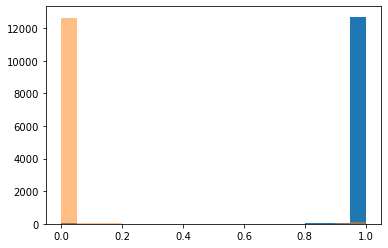

In [188]:
plt.hist(dum_clf.predict_proba(X)[y==1,1],bins=20);
plt.hist(dum_clf.predict_proba(X)[y==0,1],bins=20,alpha=0.5);

### this is much much better than using original time series

In [222]:
shap_values = shap.TreeExplainer(dum_clf).shap_values(X[:500])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


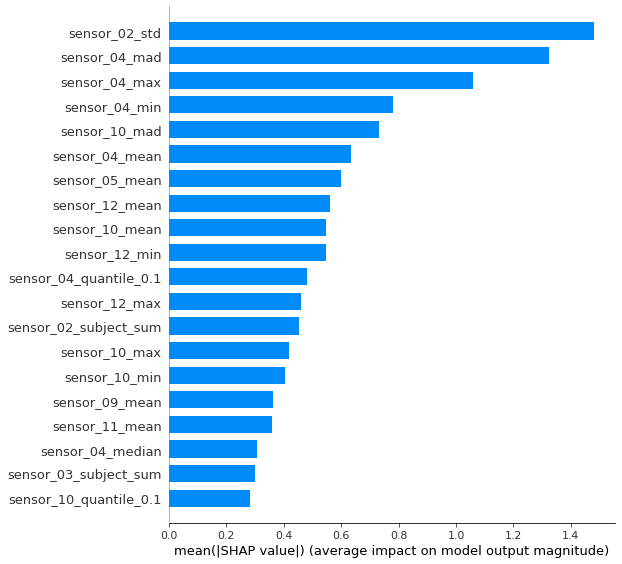

In [223]:
shap.summary_plot(shap_values, plot_type='bar', \
                  features=train.drop(columns=['sequence','subject','label']).columns)

### 02, 04, 05, 10, 12

(0.0, 1.0)

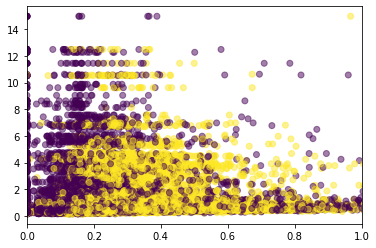

In [197]:
plt.scatter(train['sensor_02_std'].values, train['sensor_02_subject_std'].values,c=train['label'],alpha=0.5)
plt.xlim([0,1])

### the one seems broken is the most important one

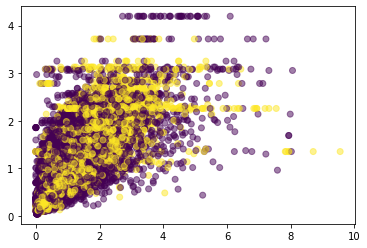

In [226]:
plt.scatter(train['sensor_04_mad'].values, train['sensor_04_subject_mad'].values,c=train['label'],alpha=0.5)

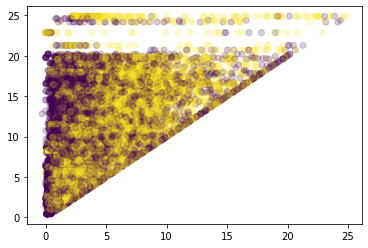

In [219]:
plt.scatter(train['sensor_04_max'].values, train['sensor_04_subject_max'].values,
            c=train['label'], alpha=0.2);

(-0.2, 0.2)

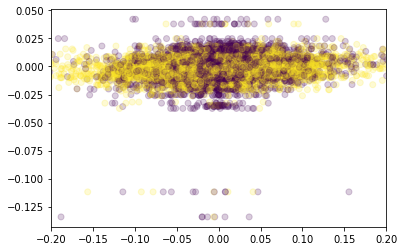

In [221]:
plt.scatter(train['sensor_05_mean'].values, train['sensor_05_subject_mean'].values,
            c=train['label'], alpha=0.2);
plt.xlim([-0.2,0.2])

### adds K mean

In [228]:
def distance(a,b):
    return np.corrcoef(a,b)

In [229]:
from sklearn.cluster import KMeans

In [230]:
class KMean_featurizer():
    def __init__(self, k=100, target_scale=5.0, random_state=None):
        self.k = k
        self.random_state = random_state
        self.target_scale = target_scale
    
    def fit(self, X, y=None):
        ''' choose whether the class info is in the clustering '''
        if (y is None):
            km_model = KMeans(n_clusters=self.k, 
                              n_init=20, 
                              verbose = 1,
                              random_state = self.random_state)
            km_model.fit(X)
        else:
            km_model_pretrain = KMeans(n_clusters=self.k, 
                                       n_init=20, 
                                       verbose = 1,
                                       random_state = self.random_state)
            # this np.newaxis seems much easier to understand
            km_model_pretrain.fit(np.hstack([X, y[:,np.newaxis] * self.target_scale]))
            cluster_centers = km_model_pretrain.cluster_centers_[:, :-1]
            
            km_model = KMeans(n_clusters=self.k, random_state = self.random_state,
                              init = cluster_centers,
                              n_init = 1,
                              max_iter = 1)
            km_model.fit(X)
        self.km_model = km_model
        self.cluster_centers_ = km_model.cluster_centers_
        return self
    
    def transform(self, X):
        return self.km_model.predict(X)[:, np.newaxis]

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [234]:
train

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_12_subject_std,sensor_12_subject_median,sensor_12_subject_mad,sensor_12_subject_min,sensor_12_subject_max,sensor_12_subject_sum,sensor_12_subject_skew,sensor_12_subject_quantile_0.1,sensor_12_subject_quantile_0.9,label
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,20.293662,-0.254476,12.579934,-312.621910,213.832481,-491.551151,-0.709353,-18.520588,19.573359,0
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,46.380511,-0.006181,21.210487,-317.453112,268.698210,-1189.222933,-0.249052,-41.808824,36.950000,1
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,46.380511,-0.006181,21.210487,-317.453112,268.698210,-1189.222933,-0.249052,-41.808824,36.950000,1
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,0.533071,-0.012788,0.349181,-3.136829,3.487639,6.289855,0.321107,-0.538107,0.558227,1
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0.318285,0.003410,0.216635,-2.805200,2.629156,3.347826,-0.224039,-0.394288,0.387937,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,558,0.100773,1.547826,0.193586,1.166378,-3.738022,3.974498,6.046368,0.069687,...,0.297025,0.000000,0.111824,-3.891731,3.270247,-1.145780,-0.326786,-0.095098,0.094203,1
25964,25964,297,0.017182,1.054727,0.051777,0.646433,-5.220247,2.927357,1.030912,-1.690229,...,18.677115,0.196718,13.164836,-108.615942,115.808610,-633.145780,-0.251035,-23.286317,21.381714,0
25965,25965,129,-0.006466,1.227428,-0.039413,0.952644,-3.422720,2.818393,-0.387944,-0.142272,...,2.322215,-0.011935,0.738890,-20.924979,43.253623,165.036232,9.266831,-0.800980,0.857630,1
25966,25966,170,-0.040417,0.885836,-0.051391,0.679951,-2.069552,1.710974,-2.425039,-0.259944,...,17.436656,-0.071611,11.035926,-126.449275,135.049872,-817.909207,0.418854,-19.131245,17.644672,1


In [236]:
X1 = series['sensor_02'].values.reshape(-1,60)
kmf_hint = KMean_featurizer()
kmf_hint.fit(X1,y)

Initialization complete
Iteration 0, inertia 434608.30625040235
Iteration 1, inertia 338472.2571028455
Iteration 2, inertia 330899.38340878
Iteration 3, inertia 326923.2076438775
Iteration 4, inertia 325495.1676689499
Iteration 5, inertia 324395.4172107679
Iteration 6, inertia 323768.52098383266
Iteration 7, inertia 323426.3039824392
Iteration 8, inertia 322633.80603235605
Iteration 9, inertia 322469.8723681043
Iteration 10, inertia 322349.46382778423
Iteration 11, inertia 322252.9477489644
Iteration 12, inertia 322190.86796774133
Iteration 13, inertia 322146.11319456855
Iteration 14, inertia 322104.64548090077
Iteration 15, inertia 322065.75935719535
Iteration 16, inertia 321787.4506058686
Iteration 17, inertia 321751.176824391
Iteration 18, inertia 321717.79543887236
Iteration 19, inertia 321684.8364876844
Iteration 20, inertia 321650.0870864175
Iteration 21, inertia 321609.3949175661
Iteration 22, inertia 321544.89261705533
Iteration 23, inertia 321467.78455076396
Iteration 24, iner

Iteration 32, inertia 315874.4306316831
Iteration 33, inertia 315869.58954037726
Iteration 34, inertia 315866.48509079334
Iteration 35, inertia 315862.38395562756
Iteration 36, inertia 315856.4839370807
Iteration 37, inertia 315851.9176097402
Iteration 38, inertia 315849.3674011697
Iteration 39, inertia 315841.6391261577
Iteration 40, inertia 315838.8816841462
Iteration 41, inertia 315836.8578304979
Iteration 42, inertia 315834.4367258332
Iteration 43, inertia 315832.08557921567
Iteration 44, inertia 315828.1580874176
Iteration 45, inertia 315826.5774878218
Iteration 46, inertia 315825.42134987167
Iteration 47, inertia 315824.20482875005
Converged at iteration 47: center shift 0.0002303007370981123 within tolerance 0.0005296669775286351.
Initialization complete
Iteration 0, inertia 426908.7921513363
Iteration 1, inertia 331228.2976544762
Iteration 2, inertia 324542.78723016696
Iteration 3, inertia 322573.5825577475
Iteration 4, inertia 321962.5337391464
Iteration 5, inertia 321599.0686

Iteration 38, inertia 317091.79399028793
Iteration 39, inertia 317080.2714805951
Iteration 40, inertia 317076.419992644
Iteration 41, inertia 317074.06972953957
Iteration 42, inertia 317071.3687801009
Iteration 43, inertia 317069.00157051766
Converged at iteration 43: center shift 0.0004934966337961568 within tolerance 0.0005296669775286351.
Initialization complete
Iteration 0, inertia 425754.6988722612
Iteration 1, inertia 330626.8454747103
Iteration 2, inertia 324460.5328596904
Iteration 3, inertia 322927.4832536721
Iteration 4, inertia 321912.7256137054
Iteration 5, inertia 321155.6370598767
Iteration 6, inertia 320600.39289864426
Iteration 7, inertia 320321.3414433351
Iteration 8, inertia 320100.7920971124
Iteration 9, inertia 319955.70759313594
Iteration 10, inertia 319824.40813928144
Iteration 11, inertia 319702.7756523385
Iteration 12, inertia 319567.824368322
Iteration 13, inertia 319449.8038469852
Iteration 14, inertia 319361.64684238844
Iteration 15, inertia 319276.2651564551

Initialization complete
Iteration 0, inertia 429688.0141674386
Iteration 1, inertia 332720.938905027
Iteration 2, inertia 324722.9552121968
Iteration 3, inertia 321930.4833571718
Iteration 4, inertia 320648.7204485361
Iteration 5, inertia 319518.959862425
Iteration 6, inertia 318332.66645058093
Iteration 7, inertia 317534.3195992315
Iteration 8, inertia 317036.8715845675
Iteration 9, inertia 316750.5755447897
Iteration 10, inertia 316551.57506623067
Iteration 11, inertia 316343.15799943684
Iteration 12, inertia 316119.4756397556
Iteration 13, inertia 315961.84277827677
Iteration 14, inertia 315854.689740008
Iteration 15, inertia 315808.19057450694
Iteration 16, inertia 315789.80687523127
Iteration 17, inertia 315781.7797931167
Iteration 18, inertia 315769.69968760345
Iteration 19, inertia 315757.90539629676
Iteration 20, inertia 315748.3962894539
Iteration 21, inertia 315742.44346114784
Iteration 22, inertia 315734.3437978123
Iteration 23, inertia 315723.7933286157
Iteration 24, inerti

Iteration 40, inertia 315221.13245374255
Iteration 41, inertia 315215.19018294837
Iteration 42, inertia 315210.0912212838
Iteration 43, inertia 315205.05726251774
Iteration 44, inertia 315200.9139207593
Iteration 45, inertia 315199.1667233247
Iteration 46, inertia 315197.54672476323
Iteration 47, inertia 315196.5454061754
Converged at iteration 47: center shift 0.0003966975762237756 within tolerance 0.0005296669775286351.
Initialization complete
Iteration 0, inertia 422412.0076633078
Iteration 1, inertia 336455.13054673193
Iteration 2, inertia 332250.31461228617
Iteration 3, inertia 331272.14572381845
Iteration 4, inertia 330731.29712263757
Iteration 5, inertia 330352.862981934
Iteration 6, inertia 330004.75455527374
Iteration 7, inertia 329611.5235755968
Iteration 8, inertia 329071.44162139815
Iteration 9, inertia 328524.0335156514
Iteration 10, inertia 328139.609403027
Iteration 11, inertia 327907.1237531073
Iteration 12, inertia 327758.15933791193
Iteration 13, inertia 327626.348576

In [241]:
train['sensor_02_kmean'] = kmf_hint.transform(X1)[:,0]

In [242]:
train.head()

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_12_subject_median,sensor_12_subject_mad,sensor_12_subject_min,sensor_12_subject_max,sensor_12_subject_sum,sensor_12_subject_skew,sensor_12_subject_quantile_0.1,sensor_12_subject_quantile_0.9,label,sensor_02_kmean
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,-0.254476,12.579934,-312.621910,213.832481,-491.551151,-0.709353,-18.520588,19.573359,0,53
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,-0.006181,21.210487,-317.453112,268.698210,-1189.222933,-0.249052,-41.808824,36.950000,1,4
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,-0.006181,21.210487,-317.453112,268.698210,-1189.222933,-0.249052,-41.808824,36.950000,1,88
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,-0.012788,0.349181,-3.136829,3.487639,6.289855,0.321107,-0.538107,0.558227,1,53
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0.003410,0.216635,-2.805200,2.629156,3.347826,-0.224039,-0.394288,0.387937,1,94


In [245]:
pd.get_dummies(train, columns=['sensor_02_kmean'],drop_first=True)

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_02_kmean_90,sensor_02_kmean_91,sensor_02_kmean_92,sensor_02_kmean_93,sensor_02_kmean_94,sensor_02_kmean_95,sensor_02_kmean_96,sensor_02_kmean_97,sensor_02_kmean_98,sensor_02_kmean_99
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,0,0,0,0,0,0,0,0,0,0
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,0,0,0,0,0,0,0,0,0,0
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,0,0,0,0,0,0,0,0,0,0
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,0,0,0,0,0,0,0,0,0,0
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,558,0.100773,1.547826,0.193586,1.166378,-3.738022,3.974498,6.046368,0.069687,...,0,0,0,0,0,0,0,0,0,0
25964,25964,297,0.017182,1.054727,0.051777,0.646433,-5.220247,2.927357,1.030912,-1.690229,...,0,0,0,0,0,0,0,0,0,0
25965,25965,129,-0.006466,1.227428,-0.039413,0.952644,-3.422720,2.818393,-0.387944,-0.142272,...,0,0,0,0,0,0,0,0,0,0
25966,25966,170,-0.040417,0.885836,-0.051391,0.679951,-2.069552,1.710974,-2.425039,-0.259944,...,0,0,0,0,0,0,0,0,0,0


In [247]:
for sensor in ['sensor_02','sensor_04','sensor_05','sensor_10','sensor_12']:
    X1 = series[sensor].values.reshape(-1,60)
    kmf_hint.fit(X1,y)
    train[sensor + '_kmean'] = kmf_hint.transform(X1)[:,0]

Initialization complete
Iteration 0, inertia 426436.74648137
Iteration 1, inertia 329551.4774350602
Iteration 2, inertia 322947.1990212331
Iteration 3, inertia 321223.4362495637
Iteration 4, inertia 320165.9295320695
Iteration 5, inertia 319698.3781526077
Iteration 6, inertia 319443.8001861104
Iteration 7, inertia 319296.27590616664
Iteration 8, inertia 319184.00118270685
Iteration 9, inertia 319079.82109352015
Iteration 10, inertia 319003.0639874403
Iteration 11, inertia 318933.89320715546
Iteration 12, inertia 318857.0743344819
Iteration 13, inertia 318688.76626715297
Iteration 14, inertia 318495.51126742945
Iteration 15, inertia 318252.1101299188
Iteration 16, inertia 317965.10745726083
Iteration 17, inertia 317668.0023103178
Iteration 18, inertia 317472.0625355548
Iteration 19, inertia 317306.53514324
Iteration 20, inertia 317114.1243076336
Iteration 21, inertia 316964.6632411568
Iteration 22, inertia 316809.53735294053
Iteration 23, inertia 316650.00472066365
Iteration 24, inertia

Initialization complete
Iteration 0, inertia 418709.9462193487
Iteration 1, inertia 327000.14250598184
Iteration 2, inertia 318701.2693269099
Iteration 3, inertia 315507.04918784305
Iteration 4, inertia 314145.35737609386
Iteration 5, inertia 313513.5777490573
Iteration 6, inertia 313088.899276006
Iteration 7, inertia 312849.41832141695
Iteration 8, inertia 312629.23930764105
Iteration 9, inertia 312467.80236832553
Iteration 10, inertia 312361.32337100175
Iteration 11, inertia 312281.4709963468
Iteration 12, inertia 312206.45262631064
Iteration 13, inertia 312152.955771935
Iteration 14, inertia 312106.77952517197
Iteration 15, inertia 312051.60540347546
Iteration 16, inertia 312001.14054862433
Iteration 17, inertia 311962.685528236
Iteration 18, inertia 311910.4452552119
Iteration 19, inertia 311866.37662468106
Iteration 20, inertia 311817.8738947302
Iteration 21, inertia 311783.9045502703
Iteration 22, inertia 311756.27189079253
Iteration 23, inertia 311727.12372156326
Iteration 24, i

Initialization complete
Iteration 0, inertia 430082.3449418647
Iteration 1, inertia 332482.4183369711
Iteration 2, inertia 324540.60005494393
Iteration 3, inertia 322207.3089093351
Iteration 4, inertia 320668.7822359127
Iteration 5, inertia 319562.5306660938
Iteration 6, inertia 318667.0164997596
Iteration 7, inertia 317531.87164759345
Iteration 8, inertia 316835.29757691675
Iteration 9, inertia 316386.4006569816
Iteration 10, inertia 316131.72828442126
Iteration 11, inertia 315975.1439225673
Iteration 12, inertia 315866.52067974024
Iteration 13, inertia 315802.3151818589
Iteration 14, inertia 315755.927270412
Iteration 15, inertia 315718.99533965095
Iteration 16, inertia 315684.72766488907
Iteration 17, inertia 315656.25902141136
Iteration 18, inertia 315624.52563592076
Iteration 19, inertia 315601.8630483664
Iteration 20, inertia 315576.0319808971
Iteration 21, inertia 315546.1985271792
Iteration 22, inertia 315524.2667163496
Iteration 23, inertia 315499.9269106962
Iteration 24, iner

Iteration 109, inertia 318577.1772300244
Iteration 110, inertia 318573.70290478406
Iteration 111, inertia 318568.0113344964
Iteration 112, inertia 318548.519469841
Iteration 113, inertia 318498.44389633776
Iteration 114, inertia 318440.81208406115
Iteration 115, inertia 318381.9730079373
Iteration 116, inertia 318289.7978182373
Iteration 117, inertia 318245.5167253901
Iteration 118, inertia 318222.35634419275
Iteration 119, inertia 318205.45561868534
Iteration 120, inertia 318190.43357127754
Iteration 121, inertia 318181.93384527456
Iteration 122, inertia 318177.9313438929
Iteration 123, inertia 318173.75661534094
Iteration 124, inertia 318172.04490980506
Iteration 125, inertia 318170.35584909597
Converged at iteration 125: center shift 0.0003036688534799846 within tolerance 0.0005296669775286351.
Initialization complete
Iteration 0, inertia 432525.28828665253
Iteration 1, inertia 333705.33632983733
Iteration 2, inertia 326466.6473600576
Iteration 3, inertia 324569.7411727227
Iteration

Iteration 113, inertia 323197.33741441084
Iteration 114, inertia 323195.44421734166
Iteration 115, inertia 323194.27954533504
Converged at iteration 115: center shift 0.0004507639993566367 within tolerance 0.0005296669775286351.
Initialization complete
Iteration 0, inertia 411361.7629088642
Iteration 1, inertia 330791.15815492044
Iteration 2, inertia 324814.3683827149
Iteration 3, inertia 322745.77643070323
Iteration 4, inertia 321580.2263130465
Iteration 5, inertia 320767.3525181711
Iteration 6, inertia 320025.3159687518
Iteration 7, inertia 319320.4194920783
Iteration 8, inertia 318875.8246225374
Iteration 9, inertia 318640.45320725243
Iteration 10, inertia 318481.9906214528
Iteration 11, inertia 318292.53980548045
Iteration 12, inertia 318125.03187825537
Iteration 13, inertia 318003.10337924334
Iteration 14, inertia 317920.6775033063
Iteration 15, inertia 317873.0364721344
Iteration 16, inertia 317856.7279512607
Iteration 17, inertia 317844.84941199404
Iteration 18, inertia 317835.9

Iteration 39, inertia 320019.4667051414
Iteration 40, inertia 320015.07667561586
Iteration 41, inertia 320011.259589985
Iteration 42, inertia 320006.7150509886
Iteration 43, inertia 320001.63147531333
Iteration 44, inertia 319996.20442074875
Iteration 45, inertia 319991.61536171695
Iteration 46, inertia 319988.10710244515
Iteration 47, inertia 319984.619976586
Iteration 48, inertia 319982.1599619233
Converged at iteration 48: center shift 0.0005271157702314234 within tolerance 0.0005296669775286351.
Initialization complete
Iteration 0, inertia 413173.8471941666
Iteration 1, inertia 327249.641020751
Iteration 2, inertia 323755.42891753325
Iteration 3, inertia 322594.115554487
Iteration 4, inertia 321830.98647407093
Iteration 5, inertia 321217.25877355866
Iteration 6, inertia 320585.59509818867
Iteration 7, inertia 320024.02425019286
Iteration 8, inertia 319620.5542092998
Iteration 9, inertia 319329.61398590705
Iteration 10, inertia 319071.17580069345
Iteration 11, inertia 318831.8706144

Iteration 22, inertia 3372356.8473417293
Iteration 23, inertia 3371597.230366515
Iteration 24, inertia 3371193.3277006624
Iteration 25, inertia 3370835.3600645927
Iteration 26, inertia 3370516.071424183
Iteration 27, inertia 3370215.7379271723
Iteration 28, inertia 3369964.4592011967
Iteration 29, inertia 3369701.014376862
Iteration 30, inertia 3369457.1368261185
Iteration 31, inertia 3369230.523927167
Iteration 32, inertia 3368869.234484998
Iteration 33, inertia 3368574.9808356413
Iteration 34, inertia 3368333.37396136
Iteration 35, inertia 3368104.7672219174
Iteration 36, inertia 3367918.76948884
Iteration 37, inertia 3367789.8436329993
Iteration 38, inertia 3367579.550354681
Iteration 39, inertia 3367309.171122024
Iteration 40, inertia 3367009.837989713
Iteration 41, inertia 3366800.843654856
Iteration 42, inertia 3366482.414022874
Iteration 43, inertia 3366062.738306237
Iteration 44, inertia 3365809.601892376
Iteration 45, inertia 3365623.302081085
Iteration 46, inertia 3365467.211

Iteration 23, inertia 3371801.2962085195
Iteration 24, inertia 3371389.0143348807
Iteration 25, inertia 3371139.44229393
Iteration 26, inertia 3370932.3624088513
Iteration 27, inertia 3370677.4993007043
Iteration 28, inertia 3370389.4328632588
Iteration 29, inertia 3370185.806603918
Iteration 30, inertia 3369951.8720926633
Iteration 31, inertia 3369560.57779275
Iteration 32, inertia 3369242.232864941
Iteration 33, inertia 3368998.685681289
Iteration 34, inertia 3368747.5988312783
Iteration 35, inertia 3368277.041594728
Iteration 36, inertia 3367833.6674580285
Iteration 37, inertia 3367319.5998529573
Iteration 38, inertia 3366700.8334998786
Iteration 39, inertia 3366304.39115522
Iteration 40, inertia 3366037.0077910516
Iteration 41, inertia 3365756.8886440215
Iteration 42, inertia 3365598.148520079
Iteration 43, inertia 3365351.4759452245
Iteration 44, inertia 3364759.5447516274
Iteration 45, inertia 3364332.50670492
Iteration 46, inertia 3363934.4581260723
Iteration 47, inertia 3363562

Iteration 61, inertia 3354428.210297505
Iteration 62, inertia 3354422.9285629187
Iteration 63, inertia 3354415.2937828503
Iteration 64, inertia 3354405.964835556
Iteration 65, inertia 3354400.9977323357
Iteration 66, inertia 3354398.743917205
Iteration 67, inertia 3354397.8743269583
Iteration 68, inertia 3354397.3374891616
Iteration 69, inertia 3354395.936584753
Iteration 70, inertia 3354391.474247656
Iteration 71, inertia 3354389.529375925
Iteration 72, inertia 3354387.0321427323
Iteration 73, inertia 3354384.6328357025
Iteration 74, inertia 3354381.888583058
Iteration 75, inertia 3354380.420289508
Iteration 76, inertia 3354379.3279457483
Iteration 77, inertia 3354378.530223729
Converged at iteration 77: center shift 0.00014085651115246692 within tolerance 0.00028906756326657813.
Initialization complete
Iteration 0, inertia 3792896.8923051953
Iteration 1, inertia 3575867.0628046473
Iteration 2, inertia 3507205.974108936
Iteration 3, inertia 3469785.6124651143
Iteration 4, inertia 3448

Iteration 60, inertia 3366083.8035926274
Iteration 61, inertia 3365893.0027526165
Iteration 62, inertia 3365773.943358732
Iteration 63, inertia 3365696.396407771
Iteration 64, inertia 3365599.7661540234
Iteration 65, inertia 3365540.237151476
Iteration 66, inertia 3365469.8700728053
Iteration 67, inertia 3365440.2217944697
Iteration 68, inertia 3365425.3688890496
Iteration 69, inertia 3365419.2515001954
Iteration 70, inertia 3365413.967196072
Iteration 71, inertia 3365412.0478784656
Iteration 72, inertia 3365411.610237046
Iteration 73, inertia 3365409.9506094377
Iteration 74, inertia 3365409.5185051626
Converged at iteration 74: center shift 9.719191096828518e-05 within tolerance 0.00028906756326657813.
Initialization complete
Iteration 0, inertia 3807161.7962785726
Iteration 1, inertia 3573539.5759502663
Iteration 2, inertia 3511050.3912736457
Iteration 3, inertia 3478637.6118514813
Iteration 4, inertia 3458470.972122976
Iteration 5, inertia 3443441.495188633
Iteration 6, inertia 3429

Iteration 62, inertia 3371634.1220628875
Iteration 63, inertia 3371515.5295324456
Iteration 64, inertia 3371414.0794655886
Iteration 65, inertia 3371288.7399588837
Iteration 66, inertia 3371185.9944062233
Iteration 67, inertia 3371090.884204001
Iteration 68, inertia 3370984.5788248363
Iteration 69, inertia 3370914.9059249726
Iteration 70, inertia 3370873.7023523445
Iteration 71, inertia 3370841.4262024546
Iteration 72, inertia 3370817.3644478945
Iteration 73, inertia 3370804.1374887535
Iteration 74, inertia 3370800.1737639313
Iteration 75, inertia 3370797.32045996
Iteration 76, inertia 3370795.349665663
Iteration 77, inertia 3370791.912726314
Iteration 78, inertia 3370786.8641769197
Iteration 79, inertia 3370783.684605455
Iteration 80, inertia 3370780.3145893672
Iteration 81, inertia 3370763.062683814
Iteration 82, inertia 3370757.5810469636
Iteration 83, inertia 3370729.3867363613
Iteration 84, inertia 3370710.2912582266
Iteration 85, inertia 3370688.5747537725
Iteration 86, inertia 3

Initialization complete
Iteration 0, inertia 3776914.979407938
Iteration 1, inertia 3544490.56842828
Iteration 2, inertia 3487716.3371846303
Iteration 3, inertia 3455506.1798801627
Iteration 4, inertia 3436308.7839872143
Iteration 5, inertia 3423193.6969419275
Iteration 6, inertia 3413638.5194718344
Iteration 7, inertia 3406426.4129236145
Iteration 8, inertia 3401343.1431722995
Iteration 9, inertia 3396328.931479672
Iteration 10, inertia 3392319.757447738
Iteration 11, inertia 3389317.207163283
Iteration 12, inertia 3387034.2330531534
Iteration 13, inertia 3385347.4880443644
Iteration 14, inertia 3383875.277302974
Iteration 15, inertia 3382433.7605793457
Iteration 16, inertia 3380371.653386168
Iteration 17, inertia 3379279.256924976
Iteration 18, inertia 3378084.3396696793
Iteration 19, inertia 3376892.8694186895
Iteration 20, inertia 3376067.25140658
Iteration 21, inertia 3375018.1744535016
Iteration 22, inertia 3373900.453838787
Iteration 23, inertia 3373085.053582676
Iteration 24, i

Iteration 21, inertia 3369244.9183093943
Iteration 22, inertia 3368522.4688761258
Iteration 23, inertia 3367975.504965613
Iteration 24, inertia 3367447.7981187208
Iteration 25, inertia 3367064.384329047
Iteration 26, inertia 3366691.406070889
Iteration 27, inertia 3366215.733010621
Iteration 28, inertia 3365906.5101315267
Iteration 29, inertia 3365610.6642950666
Iteration 30, inertia 3365233.6457456574
Iteration 31, inertia 3364938.987456361
Iteration 32, inertia 3364653.847450879
Iteration 33, inertia 3364397.8487111125
Iteration 34, inertia 3364144.8683056566
Iteration 35, inertia 3363845.3838571897
Iteration 36, inertia 3363594.6380305067
Iteration 37, inertia 3363454.1213407535
Iteration 38, inertia 3363313.2624974623
Iteration 39, inertia 3363178.5724805575
Iteration 40, inertia 3362796.203206903
Iteration 41, inertia 3362492.420372113
Iteration 42, inertia 3362263.942690722
Iteration 43, inertia 3362078.000385013
Iteration 44, inertia 3361828.172395227
Iteration 45, inertia 33616

Initialization complete
Iteration 0, inertia 3387190.4797918294
Iteration 1, inertia 3240559.522082
Iteration 2, inertia 3199334.143545146
Iteration 3, inertia 3176854.2389233406
Iteration 4, inertia 3161436.827012432
Iteration 5, inertia 3150933.313812374
Iteration 6, inertia 3143962.1102926736
Iteration 7, inertia 3138219.185158983
Iteration 8, inertia 3133779.783669564
Iteration 9, inertia 3130338.549335894
Iteration 10, inertia 3127490.43509918
Iteration 11, inertia 3125392.5513890707
Iteration 12, inertia 3123800.6518275784
Iteration 13, inertia 3122618.9413972255
Iteration 14, inertia 3121643.345909433
Iteration 15, inertia 3120756.1840363313
Iteration 16, inertia 3120133.7110043094
Iteration 17, inertia 3119613.2177125844
Iteration 18, inertia 3119078.7368638134
Iteration 19, inertia 3118589.1165744103
Iteration 20, inertia 3118093.518213554
Iteration 21, inertia 3117631.281401923
Iteration 22, inertia 3117061.8987892885
Iteration 23, inertia 3116321.071786022
Iteration 24, iner

Iteration 16, inertia 3131309.0191521747
Iteration 17, inertia 3130316.81914651
Iteration 18, inertia 3129499.7350578057
Iteration 19, inertia 3128772.5928248707
Iteration 20, inertia 3128038.017920065
Iteration 21, inertia 3127433.097084418
Iteration 22, inertia 3126892.2562217927
Iteration 23, inertia 3126375.2798190047
Iteration 24, inertia 3125858.3854160793
Iteration 25, inertia 3125315.947541594
Iteration 26, inertia 3124827.095633773
Iteration 27, inertia 3124231.307739155
Iteration 28, inertia 3123735.0559394723
Iteration 29, inertia 3123353.9895453593
Iteration 30, inertia 3123065.889261896
Iteration 31, inertia 3122824.3907456114
Iteration 32, inertia 3122627.227992602
Iteration 33, inertia 3122466.0377413034
Iteration 34, inertia 3121943.298944858
Iteration 35, inertia 3121706.4693465214
Iteration 36, inertia 3121409.133680257
Iteration 37, inertia 3120852.6719996906
Iteration 38, inertia 3120388.8717742334
Iteration 39, inertia 3119986.892935852
Iteration 40, inertia 311967

Iteration 48, inertia 3102112.5345887006
Iteration 49, inertia 3101988.403609221
Iteration 50, inertia 3101868.9434723607
Iteration 51, inertia 3101734.019323888
Iteration 52, inertia 3101589.9413953777
Iteration 53, inertia 3101469.3126160926
Iteration 54, inertia 3101354.5841630837
Iteration 55, inertia 3101274.1594078145
Iteration 56, inertia 3101190.555194867
Iteration 57, inertia 3101136.5409633582
Iteration 58, inertia 3101096.2879247074
Iteration 59, inertia 3101054.9681180175
Iteration 60, inertia 3101019.4577098717
Iteration 61, inertia 3100979.162257803
Iteration 62, inertia 3100947.284544784
Iteration 63, inertia 3100886.8455809774
Iteration 64, inertia 3100820.4271867317
Iteration 65, inertia 3100754.363222439
Iteration 66, inertia 3100631.319388816
Iteration 67, inertia 3100491.2404938284
Iteration 68, inertia 3100430.1356922872
Iteration 69, inertia 3100355.6201360654
Iteration 70, inertia 3100303.446932568
Iteration 71, inertia 3100270.342514895
Iteration 72, inertia 310

Iteration 51, inertia 3113501.2619458707
Iteration 52, inertia 3113481.897502256
Iteration 53, inertia 3113464.491324574
Iteration 54, inertia 3113446.690815325
Iteration 55, inertia 3113435.8135740445
Iteration 56, inertia 3113419.842476984
Iteration 57, inertia 3113412.46127747
Iteration 58, inertia 3113406.774904352
Iteration 59, inertia 3113401.5582516324
Iteration 60, inertia 3113391.8847115245
Iteration 61, inertia 3113387.2432447793
Iteration 62, inertia 3113384.145337318
Iteration 63, inertia 3113382.114372689
Iteration 64, inertia 3113381.6118445876
Iteration 65, inertia 3113380.6265962613
Iteration 66, inertia 3113379.3461631583
Iteration 67, inertia 3113378.6128589897
Iteration 68, inertia 3113377.2284849053
Converged at iteration 68: strict convergence.
Initialization complete
Iteration 0, inertia 3374995.707753937
Iteration 1, inertia 3239910.364217254
Iteration 2, inertia 3199846.873201756
Iteration 3, inertia 3176232.3546966626
Iteration 4, inertia 3161572.60664267
Itera

Iteration 47, inertia 3106425.247603866
Iteration 48, inertia 3106284.231066304
Iteration 49, inertia 3106190.261986157
Iteration 50, inertia 3106093.5528694196
Iteration 51, inertia 3106003.659379361
Iteration 52, inertia 3105898.5789534627
Iteration 53, inertia 3105824.5454378515
Iteration 54, inertia 3105761.0308307493
Iteration 55, inertia 3105696.504832206
Iteration 56, inertia 3105619.4579172325
Iteration 57, inertia 3105580.548817261
Iteration 58, inertia 3105533.6183720394
Iteration 59, inertia 3105491.2051034295
Iteration 60, inertia 3105448.833047358
Iteration 61, inertia 3105433.653578062
Iteration 62, inertia 3105425.323740661
Iteration 63, inertia 3105410.907762501
Iteration 64, inertia 3105398.404254754
Iteration 65, inertia 3105379.5222963523
Iteration 66, inertia 3105342.100592617
Iteration 67, inertia 3105293.237057969
Iteration 68, inertia 3105254.527666484
Iteration 69, inertia 3105212.203909554
Iteration 70, inertia 3105180.050188165
Iteration 71, inertia 3105136.33

Initialization complete
Iteration 0, inertia 3362061.6702085338
Iteration 1, inertia 3241942.889630664
Iteration 2, inertia 3203315.5228494997
Iteration 3, inertia 3181988.322102024
Iteration 4, inertia 3167059.7185479607
Iteration 5, inertia 3156183.925722326
Iteration 6, inertia 3148225.050833145
Iteration 7, inertia 3142451.933062161
Iteration 8, inertia 3137519.8308141488
Iteration 9, inertia 3132957.594792517
Iteration 10, inertia 3129415.2486953232
Iteration 11, inertia 3126593.842567265
Iteration 12, inertia 3124391.06816265
Iteration 13, inertia 3122602.435823658
Iteration 14, inertia 3121057.4716995913
Iteration 15, inertia 3119646.128697403
Iteration 16, inertia 3118482.0937183374
Iteration 17, inertia 3117555.4187086197
Iteration 18, inertia 3116555.3281085556
Iteration 19, inertia 3115715.598450548
Iteration 20, inertia 3115197.0165275196
Iteration 21, inertia 3114835.88773279
Iteration 22, inertia 3114510.0733604305
Iteration 23, inertia 3114221.9113842966
Iteration 24, in

Iteration 44, inertia 3106647.1429140302
Iteration 45, inertia 3106610.6095226808
Iteration 46, inertia 3106574.3081590408
Iteration 47, inertia 3106554.2220006753
Iteration 48, inertia 3106530.757820002
Iteration 49, inertia 3106511.633753624
Iteration 50, inertia 3106481.2572584082
Iteration 51, inertia 3106451.3405199605
Iteration 52, inertia 3106423.758565569
Iteration 53, inertia 3106369.992715666
Iteration 54, inertia 3106337.4127350757
Iteration 55, inertia 3106301.11235319
Iteration 56, inertia 3106234.178752634
Iteration 57, inertia 3106153.504927368
Iteration 58, inertia 3106108.857923192
Iteration 59, inertia 3106071.5088168364
Iteration 60, inertia 3106053.1394033697
Iteration 61, inertia 3106044.0458551343
Iteration 62, inertia 3106032.1587271313
Iteration 63, inertia 3106023.417305229
Iteration 64, inertia 3106011.4436511323
Iteration 65, inertia 3105995.233362345
Iteration 66, inertia 3105983.8512484003
Iteration 67, inertia 3105971.2735101166
Iteration 68, inertia 31059

Iteration 84, inertia 3106761.218498468
Iteration 85, inertia 3106757.607031394
Iteration 86, inertia 3106756.016240011
Iteration 87, inertia 3106755.0752557213
Converged at iteration 87: center shift 0.00022712667984276663 within tolerance 0.0002591568207912859.
Initialization complete
Iteration 0, inertia 3404360.7625540537
Iteration 1, inertia 3259681.919879328
Iteration 2, inertia 3218105.8762835194
Iteration 3, inertia 3196360.0880193114
Iteration 4, inertia 3181264.3204218126
Iteration 5, inertia 3170875.6130776634
Iteration 6, inertia 3163070.6216506627
Iteration 7, inertia 3157341.2268149643
Iteration 8, inertia 3151178.7285535946
Iteration 9, inertia 3147019.6284559905
Iteration 10, inertia 3143391.803252776
Iteration 11, inertia 3140625.5842500436
Iteration 12, inertia 3138117.306558728
Iteration 13, inertia 3135596.743849043
Iteration 14, inertia 3133123.4505122523
Iteration 15, inertia 3130180.538489231
Iteration 16, inertia 3127387.3908962365
Iteration 17, inertia 3125453.

Iteration 14, inertia 3125690.1800697837
Iteration 15, inertia 3124398.0043322663
Iteration 16, inertia 3123452.8427821
Iteration 17, inertia 3122491.618819546
Iteration 18, inertia 3121577.8391974126
Iteration 19, inertia 3120694.157157875
Iteration 20, inertia 3119741.3312695036
Iteration 21, inertia 3119062.369911193
Iteration 22, inertia 3118540.3948872536
Iteration 23, inertia 3117995.9773791325
Iteration 24, inertia 3117479.31534548
Iteration 25, inertia 3117055.0833371226
Iteration 26, inertia 3116626.6101960163
Iteration 27, inertia 3116221.4019235466
Iteration 28, inertia 3115856.663220753
Iteration 29, inertia 3115510.1242060657
Iteration 30, inertia 3115208.339990689
Iteration 31, inertia 3114791.7977951257
Iteration 32, inertia 3114418.5813469226
Iteration 33, inertia 3114197.3603676176
Iteration 34, inertia 3114031.9606507374
Iteration 35, inertia 3113876.150419168
Iteration 36, inertia 3113766.2485166998
Iteration 37, inertia 3113671.445165814
Iteration 38, inertia 311356

Iteration 24, inertia 4101077.059498846
Iteration 25, inertia 4100177.8614912643
Iteration 26, inertia 4099088.415508683
Iteration 27, inertia 4098184.7191955782
Iteration 28, inertia 4097291.8514735764
Iteration 29, inertia 4096676.864195278
Iteration 30, inertia 4096239.3926045294
Iteration 31, inertia 4095797.6510325004
Iteration 32, inertia 4095316.40196439
Iteration 33, inertia 4094826.5747426758
Iteration 34, inertia 4094495.30019336
Iteration 35, inertia 4094110.0993455835
Iteration 36, inertia 4093586.834613419
Iteration 37, inertia 4093026.65764072
Iteration 38, inertia 4092613.2126198024
Iteration 39, inertia 4092270.165930124
Iteration 40, inertia 4091727.89218143
Iteration 41, inertia 4091359.66475717
Iteration 42, inertia 4091117.7436594544
Iteration 43, inertia 4090885.7856216156
Iteration 44, inertia 4090731.816830502
Iteration 45, inertia 4090649.200528462
Iteration 46, inertia 4090537.0726078106
Iteration 47, inertia 4090499.9468175457
Iteration 48, inertia 4090418.385

Iteration 64, inertia 4109261.2707262337
Iteration 65, inertia 4109245.3680559355
Iteration 66, inertia 4109232.785404437
Iteration 67, inertia 4109198.853879408
Iteration 68, inertia 4109184.451055285
Iteration 69, inertia 4109168.490645259
Iteration 70, inertia 4109157.6802516794
Iteration 71, inertia 4109153.5693590357
Iteration 72, inertia 4109150.250439282
Iteration 73, inertia 4109146.5454482352
Iteration 74, inertia 4109144.692549783
Iteration 75, inertia 4109142.740818724
Iteration 76, inertia 4109141.707176141
Iteration 77, inertia 4109139.4403720223
Iteration 78, inertia 4109138.2343935473
Iteration 79, inertia 4109136.7933183326
Converged at iteration 79: center shift 0.00020763244638889592 within tolerance 0.000371822870541003.
Initialization complete
Iteration 0, inertia 4686963.483565707
Iteration 1, inertia 4289803.982486798
Iteration 2, inertia 4207879.062164049
Iteration 3, inertia 4173675.1178471013
Iteration 4, inertia 4154675.8702716357
Iteration 5, inertia 4142519.

Iteration 67, inertia 4111585.3683554935
Iteration 68, inertia 4111583.539436611
Iteration 69, inertia 4111573.0885336795
Iteration 70, inertia 4111570.5423570545
Iteration 71, inertia 4111568.921459428
Iteration 72, inertia 4111563.8923545345
Iteration 73, inertia 4111561.7144211885
Iteration 74, inertia 4111559.8974722633
Iteration 75, inertia 4111558.4290639577
Iteration 76, inertia 4111555.724687632
Iteration 77, inertia 4111554.7486315244
Iteration 78, inertia 4111553.228550883
Iteration 79, inertia 4111550.715571186
Iteration 80, inertia 4111549.9675603574
Converged at iteration 80: center shift 7.406968901509942e-05 within tolerance 0.000371822870541003.
Initialization complete
Iteration 0, inertia 4725652.897582384
Iteration 1, inertia 4346189.514573565
Iteration 2, inertia 4264024.205850687
Iteration 3, inertia 4222061.32100559
Iteration 4, inertia 4194682.601975386
Iteration 5, inertia 4174097.595499674
Iteration 6, inertia 4160996.1563324593
Iteration 7, inertia 4153017.6419

Initialization complete
Iteration 0, inertia 4724809.661844714
Iteration 1, inertia 4324649.595730964
Iteration 2, inertia 4236467.588986085
Iteration 3, inertia 4197827.827488718
Iteration 4, inertia 4174764.5732114073
Iteration 5, inertia 4158281.1220328826
Iteration 6, inertia 4145270.2141572377
Iteration 7, inertia 4135419.3026170144
Iteration 8, inertia 4128168.0693838038
Iteration 9, inertia 4122099.435355241
Iteration 10, inertia 4117921.5221095993
Iteration 11, inertia 4113068.5373218996
Iteration 12, inertia 4109471.1928257146
Iteration 13, inertia 4106748.7760909353
Iteration 14, inertia 4104427.6631225897
Iteration 15, inertia 4102543.60613428
Iteration 16, inertia 4101012.179762922
Iteration 17, inertia 4099949.4772931337
Iteration 18, inertia 4098982.9035371435
Iteration 19, inertia 4097948.9796913257
Iteration 20, inertia 4097361.768356909
Iteration 21, inertia 4096689.61340396
Iteration 22, inertia 4095745.2949275193
Iteration 23, inertia 4094947.858120264
Iteration 24, 

Iteration 66, inertia 4104741.382462604
Iteration 67, inertia 4104727.96889731
Iteration 68, inertia 4104716.9910905706
Iteration 69, inertia 4104706.6827856917
Iteration 70, inertia 4104703.217249872
Iteration 71, inertia 4104701.749910234
Converged at iteration 71: center shift 0.00026304486802582086 within tolerance 0.000371822870541003.
Initialization complete
Iteration 0, inertia 4742602.346451386
Iteration 1, inertia 4341063.820666046
Iteration 2, inertia 4239141.974639331
Iteration 3, inertia 4193708.9549477156
Iteration 4, inertia 4170678.64169438
Iteration 5, inertia 4158358.679228251
Iteration 6, inertia 4148494.9827289423
Iteration 7, inertia 4139761.2915156344
Iteration 8, inertia 4133469.2489530984
Iteration 9, inertia 4128902.47704562
Iteration 10, inertia 4125921.2051840713
Iteration 11, inertia 4123550.4364076992
Iteration 12, inertia 4121874.813441138
Iteration 13, inertia 4120553.442457475
Iteration 14, inertia 4119476.6297056833
Iteration 15, inertia 4118390.47979479

Iteration 65, inertia 4100952.7969012633
Iteration 66, inertia 4100950.8404171495
Iteration 67, inertia 4100949.627310623
Iteration 68, inertia 4100947.953271384
Converged at iteration 68: center shift 3.209738196758299e-05 within tolerance 0.000371822870541003.
Initialization complete
Iteration 0, inertia 4706712.637899982
Iteration 1, inertia 4316839.785812019
Iteration 2, inertia 4224627.733460835
Iteration 3, inertia 4179273.149266205
Iteration 4, inertia 4155868.429244284
Iteration 5, inertia 4143260.167531571
Iteration 6, inertia 4135159.2860017805
Iteration 7, inertia 4128664.9666774534
Iteration 8, inertia 4123913.5190272746
Iteration 9, inertia 4120605.479210267
Iteration 10, inertia 4117980.611254062
Iteration 11, inertia 4116385.8071204713
Iteration 12, inertia 4114991.7226011977
Iteration 13, inertia 4113412.6622236045
Iteration 14, inertia 4112356.723020265
Iteration 15, inertia 4111524.100978774
Iteration 16, inertia 4110616.7883172613
Iteration 17, inertia 4109967.913154

Initialization complete
Iteration 0, inertia 4671649.2427021675
Iteration 1, inertia 4300723.225928643
Iteration 2, inertia 4227038.044266554
Iteration 3, inertia 4195080.250280563
Iteration 4, inertia 4177218.384424491
Iteration 5, inertia 4164561.360775976
Iteration 6, inertia 4155260.920085345
Iteration 7, inertia 4148849.0446361075
Iteration 8, inertia 4143621.257487595
Iteration 9, inertia 4139493.124330772
Iteration 10, inertia 4135932.707339926
Iteration 11, inertia 4133797.750189835
Iteration 12, inertia 4132161.0967711816
Iteration 13, inertia 4130489.6606646026
Iteration 14, inertia 4128159.3042299254
Iteration 15, inertia 4126297.601933272
Iteration 16, inertia 4124262.8283837214
Iteration 17, inertia 4122375.902867941
Iteration 18, inertia 4121054.2846437134
Iteration 19, inertia 4119829.1305477275
Iteration 20, inertia 4118655.597437009
Iteration 21, inertia 4117768.6952026933
Iteration 22, inertia 4116998.812138933
Iteration 23, inertia 4116438.6530812248
Iteration 24, in

Initialization complete
Iteration 0, inertia 1750320844.0970256
Iteration 1, inertia 1604917971.0596344
Iteration 2, inertia 1574188087.2151604
Iteration 3, inertia 1561821699.685679
Iteration 4, inertia 1555254310.0326028
Iteration 5, inertia 1550579950.8068824
Iteration 6, inertia 1546591417.060343
Iteration 7, inertia 1543990921.4490905
Iteration 8, inertia 1542316715.417537
Iteration 9, inertia 1540655760.5609145
Iteration 10, inertia 1539692090.4539318
Iteration 11, inertia 1539062548.3146486
Iteration 12, inertia 1538651465.0782003
Iteration 13, inertia 1538190556.2021146
Iteration 14, inertia 1537625404.0422373
Iteration 15, inertia 1537186481.1592784
Iteration 16, inertia 1536825142.136848
Iteration 17, inertia 1536324735.509499
Iteration 18, inertia 1535871895.5693283
Iteration 19, inertia 1535424996.948311
Iteration 20, inertia 1534929014.5242703
Iteration 21, inertia 1534551617.326298
Iteration 22, inertia 1534016922.1940448
Iteration 23, inertia 1533428642.249085
Iteration 

Iteration 45, inertia 1532865011.5480084
Iteration 46, inertia 1532842338.9517035
Iteration 47, inertia 1532830803.2372725
Iteration 48, inertia 1532825631.737186
Iteration 49, inertia 1532822294.5837283
Iteration 50, inertia 1532809885.7679276
Iteration 51, inertia 1532782876.039043
Iteration 52, inertia 1532782131.806817
Converged at iteration 52: strict convergence.
Initialization complete
Iteration 0, inertia 1746138810.9494894
Iteration 1, inertia 1607059900.7223713
Iteration 2, inertia 1574662353.0919962
Iteration 3, inertia 1560542564.062929
Iteration 4, inertia 1554226127.0222983
Iteration 5, inertia 1550585547.6890163
Iteration 6, inertia 1547803960.6387901
Iteration 7, inertia 1545833375.4332395
Iteration 8, inertia 1544279047.5255117
Iteration 9, inertia 1542843509.1091673
Iteration 10, inertia 1542249325.1304243
Iteration 11, inertia 1541674788.9688444
Iteration 12, inertia 1541355238.788605
Iteration 13, inertia 1540936519.8543596
Iteration 14, inertia 1540721213.9508677
I

Iteration 46, inertia 1527298661.2164505
Iteration 47, inertia 1527271813.4709573
Iteration 48, inertia 1527245789.7030082
Iteration 49, inertia 1527221270.9731598
Iteration 50, inertia 1527211804.6053524
Iteration 51, inertia 1527193415.7836213
Iteration 52, inertia 1527185364.6709995
Iteration 53, inertia 1527169621.8777106
Iteration 54, inertia 1527150597.878662
Iteration 55, inertia 1527124815.0924847
Iteration 56, inertia 1527111021.2451406
Iteration 57, inertia 1527095779.2825284
Iteration 58, inertia 1527078604.336981
Iteration 59, inertia 1527049367.9780972
Iteration 60, inertia 1527000492.2160833
Iteration 61, inertia 1526951193.7813559
Iteration 62, inertia 1526899165.1063015
Iteration 63, inertia 1526840223.0477345
Iteration 64, inertia 1526810591.8366969
Iteration 65, inertia 1526782828.2759993
Iteration 66, inertia 1526765296.22606
Iteration 67, inertia 1526749139.2965217
Iteration 68, inertia 1526739216.4047618
Converged at iteration 68: strict convergence.
Initialization

Initialization complete
Iteration 0, inertia 1751578018.4278312
Iteration 1, inertia 1607415862.3543978
Iteration 2, inertia 1579152254.164092
Iteration 3, inertia 1567706797.7871401
Iteration 4, inertia 1559513538.3544848
Iteration 5, inertia 1554110434.5437667
Iteration 6, inertia 1550181640.2128615
Iteration 7, inertia 1547720436.0764375
Iteration 8, inertia 1545241526.1088457
Iteration 9, inertia 1543271094.9142504
Iteration 10, inertia 1541491498.3126273
Iteration 11, inertia 1540189753.324567
Iteration 12, inertia 1539317564.7528572
Iteration 13, inertia 1537823412.395112
Iteration 14, inertia 1536990165.1207638
Iteration 15, inertia 1536457300.2238116
Iteration 16, inertia 1536154307.8603888
Iteration 17, inertia 1535808629.3322124
Iteration 18, inertia 1535226392.2170703
Iteration 19, inertia 1534975748.4846344
Iteration 20, inertia 1534785419.5660472
Iteration 21, inertia 1534581793.793437
Iteration 22, inertia 1534354272.725655
Iteration 23, inertia 1534248133.4461253
Iterati

Iteration 0, inertia 1748586809.1576648
Iteration 1, inertia 1602492396.8471014
Iteration 2, inertia 1575228713.9631543
Iteration 3, inertia 1560887793.617598
Iteration 4, inertia 1552854232.128274
Iteration 5, inertia 1546562302.463621
Iteration 6, inertia 1542608870.7464764
Iteration 7, inertia 1540573042.334138
Iteration 8, inertia 1538206825.2972095
Iteration 9, inertia 1536521004.6310635
Iteration 10, inertia 1535654112.126938
Iteration 11, inertia 1534712339.169337
Iteration 12, inertia 1533954606.5093777
Iteration 13, inertia 1533265349.3816066
Iteration 14, inertia 1532641318.6209729
Iteration 15, inertia 1532353067.13669
Iteration 16, inertia 1532106744.0236871
Iteration 17, inertia 1531693307.951192
Iteration 18, inertia 1531462958.9186778
Iteration 19, inertia 1531079615.514963
Iteration 20, inertia 1530771993.6702623
Iteration 21, inertia 1530604826.9230208
Iteration 22, inertia 1530489747.212994
Iteration 23, inertia 1530391557.6161466
Iteration 24, inertia 1530326513.7291

In [248]:
train.head()

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_12_subject_sum,sensor_12_subject_skew,sensor_12_subject_quantile_0.1,sensor_12_subject_quantile_0.9,label,sensor_02_kmean,sensor_04_kmean,sensor_05_kmean,sensor_10_kmean,sensor_12_kmean
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,-491.551151,-0.709353,-18.520588,19.573359,0,7,59,31,91,0
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,-1189.222933,-0.249052,-41.808824,36.950000,1,84,42,21,91,25
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,-1189.222933,-0.249052,-41.808824,36.950000,1,94,83,20,25,0
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,6.289855,0.321107,-0.538107,0.558227,1,38,59,16,67,0
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,3.347826,-0.224039,-0.394288,0.387937,1,14,42,7,67,0


In [253]:
train = pd.get_dummies(train, drop_first=True,
               columns=['sensor_02_kmean','sensor_04_kmean','sensor_05_kmean','sensor_10_kmean','sensor_12_kmean'])

In [254]:
train.head()

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_12_kmean_90,sensor_12_kmean_91,sensor_12_kmean_92,sensor_12_kmean_93,sensor_12_kmean_94,sensor_12_kmean_95,sensor_12_kmean_96,sensor_12_kmean_97,sensor_12_kmean_98,sensor_12_kmean_99
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,0,0,0,0,0,0,0,0,0,0
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,0,0,0,0,0,0,0,0,0,0
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,0,0,0,0,0,0,0,0,0,0
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,0,0,0,0,0,0,0,0,0,0
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0,0,0,0,0,0,0,0,0,0


In [255]:
X, y = train.drop(columns=['sequence','subject','label']).values, train['label'].values

In [256]:
best_param_booster, dum_clf = gridsearch_xgboost(params, X, y)

param_fit: {'eval_metric': 'auc', 'early_stopping_rounds': 50}
param_booster: {'gamma': 0, 'max_depth': 6, 'min_child_weight': 0.0, 'n_estimators': 10000, 'learning_rate': 0.3}
[0]	validation_0-auc:0.82344
[1]	validation_0-auc:0.85306
[2]	validation_0-auc:0.86220
[3]	validation_0-auc:0.87335
[4]	validation_0-auc:0.88037
[5]	validation_0-auc:0.88889
[6]	validation_0-auc:0.89245
[7]	validation_0-auc:0.89616
[8]	validation_0-auc:0.90136
[9]	validation_0-auc:0.90420
[10]	validation_0-auc:0.90802
[11]	validation_0-auc:0.90910
[12]	validation_0-auc:0.91183
[13]	validation_0-auc:0.91338
[14]	validation_0-auc:0.91635
[15]	validation_0-auc:0.91755
[16]	validation_0-auc:0.91887
[17]	validation_0-auc:0.92000
[18]	validation_0-auc:0.92016
[19]	validation_0-auc:0.92119
[20]	validation_0-auc:0.92181
[21]	validation_0-auc:0.92271
[22]	validation_0-auc:0.92378
[23]	validation_0-auc:0.92471
[24]	validation_0-auc:0.92548
[25]	validation_0-auc:0.92604
[26]	validation_0-auc:0.92763
[27]	validation_0-auc:0

[263]	validation_0-auc:0.94414
[264]	validation_0-auc:0.94414
[265]	validation_0-auc:0.94417
[266]	validation_0-auc:0.94419
[267]	validation_0-auc:0.94417
[268]	validation_0-auc:0.94416
[269]	validation_0-auc:0.94428
[270]	validation_0-auc:0.94436
[271]	validation_0-auc:0.94438
[272]	validation_0-auc:0.94455
[273]	validation_0-auc:0.94455
[274]	validation_0-auc:0.94472
[275]	validation_0-auc:0.94467
[276]	validation_0-auc:0.94467
[277]	validation_0-auc:0.94464
[278]	validation_0-auc:0.94469
[279]	validation_0-auc:0.94472
[280]	validation_0-auc:0.94475
[281]	validation_0-auc:0.94486
[282]	validation_0-auc:0.94501
[283]	validation_0-auc:0.94487
[284]	validation_0-auc:0.94477
[285]	validation_0-auc:0.94479
[286]	validation_0-auc:0.94483
[287]	validation_0-auc:0.94477
[288]	validation_0-auc:0.94476
[289]	validation_0-auc:0.94483
[290]	validation_0-auc:0.94480
[291]	validation_0-auc:0.94483
[292]	validation_0-auc:0.94486
[293]	validation_0-auc:0.94487
[294]	validation_0-auc:0.94498
[295]	va

[528]	validation_0-auc:0.94764
[529]	validation_0-auc:0.94761
[530]	validation_0-auc:0.94760
[531]	validation_0-auc:0.94767
[532]	validation_0-auc:0.94765
[533]	validation_0-auc:0.94771
[534]	validation_0-auc:0.94768
[535]	validation_0-auc:0.94764
[536]	validation_0-auc:0.94759
[537]	validation_0-auc:0.94755
[538]	validation_0-auc:0.94762
[539]	validation_0-auc:0.94758
[540]	validation_0-auc:0.94749
[541]	validation_0-auc:0.94747
[542]	validation_0-auc:0.94743
[543]	validation_0-auc:0.94744
[544]	validation_0-auc:0.94749
[545]	validation_0-auc:0.94753
[546]	validation_0-auc:0.94751
[547]	validation_0-auc:0.94754
[548]	validation_0-auc:0.94751
[549]	validation_0-auc:0.94754
[550]	validation_0-auc:0.94761
[551]	validation_0-auc:0.94760
[552]	validation_0-auc:0.94763
[553]	validation_0-auc:0.94760
[554]	validation_0-auc:0.94757
[555]	validation_0-auc:0.94756
[556]	validation_0-auc:0.94756
[557]	validation_0-auc:0.94759
[558]	validation_0-auc:0.94759
[559]	validation_0-auc:0.94757
[560]	va

[212]	validation_0-auc:0.93829
[213]	validation_0-auc:0.93831
[214]	validation_0-auc:0.93838
[215]	validation_0-auc:0.93828
[216]	validation_0-auc:0.93831
[217]	validation_0-auc:0.93845
[218]	validation_0-auc:0.93866
[219]	validation_0-auc:0.93888
[220]	validation_0-auc:0.93894
[221]	validation_0-auc:0.93882
[222]	validation_0-auc:0.93883
[223]	validation_0-auc:0.93883
[224]	validation_0-auc:0.93912
[225]	validation_0-auc:0.93920
[226]	validation_0-auc:0.93909
[227]	validation_0-auc:0.93917
[228]	validation_0-auc:0.93909
[229]	validation_0-auc:0.93921
[230]	validation_0-auc:0.93934
[231]	validation_0-auc:0.93940
[232]	validation_0-auc:0.93940
[233]	validation_0-auc:0.93932
[234]	validation_0-auc:0.93936
[235]	validation_0-auc:0.93937
[236]	validation_0-auc:0.93949
[237]	validation_0-auc:0.93936
[238]	validation_0-auc:0.93927
[239]	validation_0-auc:0.93933
[240]	validation_0-auc:0.93922
[241]	validation_0-auc:0.93929
[242]	validation_0-auc:0.93950
[243]	validation_0-auc:0.93973
[244]	va

[157]	validation_0-auc:0.92043
[158]	validation_0-auc:0.92007
[159]	validation_0-auc:0.91997
[160]	validation_0-auc:0.91998
[161]	validation_0-auc:0.91989
[162]	validation_0-auc:0.92011
[163]	validation_0-auc:0.92020
[164]	validation_0-auc:0.92017
[165]	validation_0-auc:0.91997
[166]	validation_0-auc:0.91970
[167]	validation_0-auc:0.91980
[168]	validation_0-auc:0.91994
[169]	validation_0-auc:0.91985
[170]	validation_0-auc:0.91980
[171]	validation_0-auc:0.91995
[172]	validation_0-auc:0.92025
[173]	validation_0-auc:0.92011
[174]	validation_0-auc:0.92021
[175]	validation_0-auc:0.92024
[176]	validation_0-auc:0.92022
[177]	validation_0-auc:0.92045
[178]	validation_0-auc:0.92062
[179]	validation_0-auc:0.92080
[180]	validation_0-auc:0.92074
[181]	validation_0-auc:0.92088
[182]	validation_0-auc:0.92100
[183]	validation_0-auc:0.92080
[184]	validation_0-auc:0.92107
[185]	validation_0-auc:0.92121
[186]	validation_0-auc:0.92127
[187]	validation_0-auc:0.92144
[188]	validation_0-auc:0.92132
[189]	va

[422]	validation_0-auc:0.92972
[423]	validation_0-auc:0.92982
[424]	validation_0-auc:0.92993
[425]	validation_0-auc:0.92986
[426]	validation_0-auc:0.92988
[427]	validation_0-auc:0.92988
[428]	validation_0-auc:0.92991
[429]	validation_0-auc:0.92996
[430]	validation_0-auc:0.92998
[431]	validation_0-auc:0.92992
[432]	validation_0-auc:0.92997
[433]	validation_0-auc:0.92998
[434]	validation_0-auc:0.92997
[435]	validation_0-auc:0.93000
[436]	validation_0-auc:0.93000
[437]	validation_0-auc:0.92999
[438]	validation_0-auc:0.93000
[439]	validation_0-auc:0.93001
[440]	validation_0-auc:0.92999
[441]	validation_0-auc:0.92992
[442]	validation_0-auc:0.93005
[443]	validation_0-auc:0.93003
[444]	validation_0-auc:0.93000
[445]	validation_0-auc:0.93003
[446]	validation_0-auc:0.93011
[447]	validation_0-auc:0.93022
[448]	validation_0-auc:0.93015
[449]	validation_0-auc:0.93019
[450]	validation_0-auc:0.93014
[451]	validation_0-auc:0.93016
[452]	validation_0-auc:0.93019
[453]	validation_0-auc:0.93019
[454]	va

[687]	validation_0-auc:0.93285
[688]	validation_0-auc:0.93296
[689]	validation_0-auc:0.93289
[690]	validation_0-auc:0.93290
[691]	validation_0-auc:0.93292
[692]	validation_0-auc:0.93292
[693]	validation_0-auc:0.93293
[694]	validation_0-auc:0.93295
[695]	validation_0-auc:0.93295
[696]	validation_0-auc:0.93297
[697]	validation_0-auc:0.93297
[698]	validation_0-auc:0.93297
[699]	validation_0-auc:0.93293
[700]	validation_0-auc:0.93296
[701]	validation_0-auc:0.93295
[702]	validation_0-auc:0.93294
[703]	validation_0-auc:0.93291
[704]	validation_0-auc:0.93297
[705]	validation_0-auc:0.93296
[706]	validation_0-auc:0.93294
[707]	validation_0-auc:0.93295
[708]	validation_0-auc:0.93298
[709]	validation_0-auc:0.93298
[710]	validation_0-auc:0.93301
[711]	validation_0-auc:0.93303
[712]	validation_0-auc:0.93303
[713]	validation_0-auc:0.93303
[714]	validation_0-auc:0.93300
[715]	validation_0-auc:0.93299
[716]	validation_0-auc:0.93299
[717]	validation_0-auc:0.93300
[718]	validation_0-auc:0.93303
[719]	va

[16]	validation_0-auc:0.89863
[17]	validation_0-auc:0.89959
[18]	validation_0-auc:0.90032
[19]	validation_0-auc:0.90133
[20]	validation_0-auc:0.90259
[21]	validation_0-auc:0.90359
[22]	validation_0-auc:0.90569
[23]	validation_0-auc:0.90672
[24]	validation_0-auc:0.90862
[25]	validation_0-auc:0.90888
[26]	validation_0-auc:0.91047
[27]	validation_0-auc:0.91127
[28]	validation_0-auc:0.91182
[29]	validation_0-auc:0.91286
[30]	validation_0-auc:0.91348
[31]	validation_0-auc:0.91390
[32]	validation_0-auc:0.91357
[33]	validation_0-auc:0.91287
[34]	validation_0-auc:0.91368
[35]	validation_0-auc:0.91427
[36]	validation_0-auc:0.91442
[37]	validation_0-auc:0.91441
[38]	validation_0-auc:0.91472
[39]	validation_0-auc:0.91559
[40]	validation_0-auc:0.91584
[41]	validation_0-auc:0.91663
[42]	validation_0-auc:0.91693
[43]	validation_0-auc:0.91740
[44]	validation_0-auc:0.91754
[45]	validation_0-auc:0.91773
[46]	validation_0-auc:0.91871
[47]	validation_0-auc:0.91875
[48]	validation_0-auc:0.91837
[49]	valid

[283]	validation_0-auc:0.93001
[284]	validation_0-auc:0.93010
[285]	validation_0-auc:0.93024
[286]	validation_0-auc:0.93040
[287]	validation_0-auc:0.93033
[288]	validation_0-auc:0.93037
[289]	validation_0-auc:0.93043
[290]	validation_0-auc:0.93037
[291]	validation_0-auc:0.93049
[292]	validation_0-auc:0.93044
[293]	validation_0-auc:0.93043
[294]	validation_0-auc:0.93051
[295]	validation_0-auc:0.93053
[296]	validation_0-auc:0.93052
[297]	validation_0-auc:0.93051
[298]	validation_0-auc:0.93051
[299]	validation_0-auc:0.93055
[300]	validation_0-auc:0.93073
[301]	validation_0-auc:0.93072
[302]	validation_0-auc:0.93063
[303]	validation_0-auc:0.93059
[304]	validation_0-auc:0.93058
[305]	validation_0-auc:0.93064
[306]	validation_0-auc:0.93077
[307]	validation_0-auc:0.93075
[308]	validation_0-auc:0.93104
[309]	validation_0-auc:0.93100
[310]	validation_0-auc:0.93095
[311]	validation_0-auc:0.93097
[312]	validation_0-auc:0.93097
[313]	validation_0-auc:0.93103
[314]	validation_0-auc:0.93107
[315]	va

[548]	validation_0-auc:0.93517
[549]	validation_0-auc:0.93518
[550]	validation_0-auc:0.93520
[551]	validation_0-auc:0.93506
[552]	validation_0-auc:0.93513
[553]	validation_0-auc:0.93508
[554]	validation_0-auc:0.93508
[555]	validation_0-auc:0.93507
[556]	validation_0-auc:0.93512
[557]	validation_0-auc:0.93513
[558]	validation_0-auc:0.93512
[559]	validation_0-auc:0.93512
[560]	validation_0-auc:0.93513
[561]	validation_0-auc:0.93517
[562]	validation_0-auc:0.93515
[563]	validation_0-auc:0.93516
[564]	validation_0-auc:0.93518
[565]	validation_0-auc:0.93518
[566]	validation_0-auc:0.93523
[567]	validation_0-auc:0.93524
[568]	validation_0-auc:0.93525
[569]	validation_0-auc:0.93525
[570]	validation_0-auc:0.93527
[571]	validation_0-auc:0.93526
[572]	validation_0-auc:0.93527
[573]	validation_0-auc:0.93525
[574]	validation_0-auc:0.93535
[575]	validation_0-auc:0.93533
[576]	validation_0-auc:0.93533
[577]	validation_0-auc:0.93542
[578]	validation_0-auc:0.93541
[579]	validation_0-auc:0.93546
[580]	va

[104]	validation_0-auc:0.94044
[105]	validation_0-auc:0.94083
[106]	validation_0-auc:0.94080
[107]	validation_0-auc:0.94075
[108]	validation_0-auc:0.94086
[109]	validation_0-auc:0.94097
[110]	validation_0-auc:0.94131
[111]	validation_0-auc:0.94185
[112]	validation_0-auc:0.94216
[113]	validation_0-auc:0.94220
[114]	validation_0-auc:0.94230
[115]	validation_0-auc:0.94230
[116]	validation_0-auc:0.94249
[117]	validation_0-auc:0.94229
[118]	validation_0-auc:0.94246
[119]	validation_0-auc:0.94252
[120]	validation_0-auc:0.94261
[121]	validation_0-auc:0.94260
[122]	validation_0-auc:0.94264
[123]	validation_0-auc:0.94258
[124]	validation_0-auc:0.94268
[125]	validation_0-auc:0.94291
[126]	validation_0-auc:0.94291
[127]	validation_0-auc:0.94328
[128]	validation_0-auc:0.94320
[129]	validation_0-auc:0.94320
[130]	validation_0-auc:0.94331
[131]	validation_0-auc:0.94339
[132]	validation_0-auc:0.94388
[133]	validation_0-auc:0.94386
[134]	validation_0-auc:0.94390
[135]	validation_0-auc:0.94389
[136]	va

[369]	validation_0-auc:0.95087
[370]	validation_0-auc:0.95084
[371]	validation_0-auc:0.95091
[372]	validation_0-auc:0.95102
[373]	validation_0-auc:0.95094
[374]	validation_0-auc:0.95095
[375]	validation_0-auc:0.95100
[376]	validation_0-auc:0.95105
[377]	validation_0-auc:0.95100
[378]	validation_0-auc:0.95101
[379]	validation_0-auc:0.95102
[380]	validation_0-auc:0.95112
[381]	validation_0-auc:0.95113
[382]	validation_0-auc:0.95120
[383]	validation_0-auc:0.95123
[384]	validation_0-auc:0.95127
[385]	validation_0-auc:0.95124
[386]	validation_0-auc:0.95128
[387]	validation_0-auc:0.95128
[388]	validation_0-auc:0.95124
[389]	validation_0-auc:0.95128
[390]	validation_0-auc:0.95132
[391]	validation_0-auc:0.95129
[392]	validation_0-auc:0.95130
[393]	validation_0-auc:0.95124
[394]	validation_0-auc:0.95124
[395]	validation_0-auc:0.95130
[396]	validation_0-auc:0.95132
[397]	validation_0-auc:0.95138
[398]	validation_0-auc:0.95139
[399]	validation_0-auc:0.95143
[400]	validation_0-auc:0.95138
[401]	va

### let's take a look at sensor 4

In [257]:
train

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_12_kmean_90,sensor_12_kmean_91,sensor_12_kmean_92,sensor_12_kmean_93,sensor_12_kmean_94,sensor_12_kmean_95,sensor_12_kmean_96,sensor_12_kmean_97,sensor_12_kmean_98,sensor_12_kmean_99
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,0,0,0,0,0,0,0,0,0,0
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,0,0,0,0,0,0,0,0,0,0
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,0,0,0,0,0,0,0,0,0,0
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,0,0,0,0,0,0,0,0,0,0
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,558,0.100773,1.547826,0.193586,1.166378,-3.738022,3.974498,6.046368,0.069687,...,0,0,0,0,0,0,0,0,0,0
25964,25964,297,0.017182,1.054727,0.051777,0.646433,-5.220247,2.927357,1.030912,-1.690229,...,0,0,0,0,0,0,0,0,0,0
25965,25965,129,-0.006466,1.227428,-0.039413,0.952644,-3.422720,2.818393,-0.387944,-0.142272,...,0,0,0,0,0,0,0,0,0,0
25966,25966,170,-0.040417,0.885836,-0.051391,0.679951,-2.069552,1.710974,-2.425039,-0.259944,...,0,0,0,0,0,0,0,0,0,0


In [258]:
labels.head(20)

,state
sequence,
0,0
1,1
2,1
3,1
4,1
5,1
6,0
7,0
8,0


In [261]:
series['sequence'] == 0

0           True
1           True
2           True
3           True
4           True
           ...  
1558075    False
1558076    False
1558077    False
1558078    False
1558079    False
Name: sequence, Length: 1558080, dtype: bool

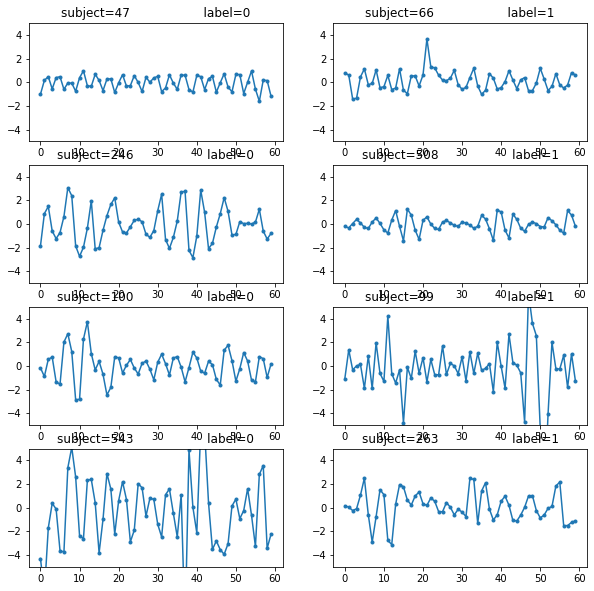

In [275]:
seqs = [0,1,6,11,14,15,19,18]
fig, axs = plt.subplots(4,2,figsize=(10,10))
axs = axs.flatten()
for idx, seq in enumerate(seqs):
    irow = (series['sequence']==seq)
    tmp = series.loc[irow,'sensor_04'].values
    ax = axs[idx]
    ax.set_title(f"subject={series.loc[irow,'subject'].iloc[0]} \
                  label={labels.loc[seq].values[0]}")
    ax.set_ylim([-5,5])
    ax.plot(tmp,'.-')

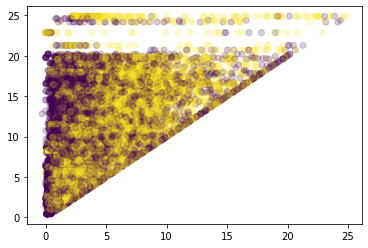

In [276]:
plt.scatter(train['sensor_04_max'].values, train['sensor_04_subject_max'].values,
            c=train['label'], alpha=0.2);

In [278]:
series

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,0,47,0,-0.196291,0.112395,1.000000,0.329204,-1.004660,-0.131638,-0.127505,0.368702,-0.1,-0.963873,-0.985069,0.531893,4.751492
1,0,47,1,-0.447450,0.134454,1.000000,-0.658407,0.162495,0.340314,-0.209472,-0.867176,0.2,-0.301301,0.082733,-0.231481,0.454390
2,0,47,2,0.326893,-0.694328,1.000000,0.330088,0.473678,1.280479,-0.094718,0.535878,1.4,1.002168,0.449221,-0.586420,-4.736147
3,0,47,3,0.523184,0.751050,1.000000,0.976991,-0.563287,-0.720269,0.793260,0.951145,-0.3,-0.995665,-0.434290,1.344650,0.429241
4,0,47,4,0.272025,1.074580,1.000000,-0.136283,0.398579,0.044877,0.560109,-0.541985,-0.9,1.055636,0.812631,0.123457,-0.223359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1558075,25967,327,55,-0.282844,-1.217437,-1.666153,0.586726,-0.930698,-0.451010,-0.651184,0.368702,0.4,0.008671,-0.723536,-0.353909,-0.914749
1558076,25967,327,56,0.130603,0.349790,-1.666153,-0.324779,0.775324,-0.332835,0.099271,0.122137,-0.2,0.644509,0.691407,-0.613169,-0.515772
1558077,25967,327,57,-0.579598,0.429622,-1.666153,0.319469,0.308861,0.282723,-0.512750,0.012214,-1.6,-0.424133,0.716855,1.628601,0.928389
1558078,25967,327,58,1.278980,1.711134,-1.522820,0.802655,-0.460541,-0.055348,2.405282,0.043511,1.9,0.283960,-0.914914,0.364198,0.211424


In [281]:
subject_means = series.groupby(['subject','step']).mean().drop(columns='sequence')

In [282]:
subject_means

sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  \
subject step                                                          
0       0      0.231337   0.227048   0.487821   0.360929  -0.550552   
        1      0.098068  -0.076786   0.517136  -0.517876   0.136421   
        2     -0.304096  -0.032038   0.501719   0.297655   0.246925   
        3     -0.071754  -0.223267   0.562766  -0.177389   0.791800   
        4      0.242813   0.295693   0.623536   0.156372  -0.624912   
...                 ...        ...        ...        ...        ...   
671     55     0.043109   0.362675  -0.398876   0.080619   0.156214   
        56    -0.460961   1.184926  -0.432539   0.702316  -0.194589   
        57     0.648789  -2.139811  -0.449012  -0.840767  -0.364196   
        58    -0.188215  -0.350998  -0.466779   0.657021   0.177618   
        59    -0.372901  -0.292209  -0.459902   0.113274   0.291231   

              sensor_05  sensor_06  sensor_07  sensor_08  sensor_09  \
subject step                                                          
0       0      0.803441   0.240027   0.202405  -0.170000   0.176734   
        1     -0.463575   0.027140  -0.533130   0.180000   0.498447   
        2      0.107218  -0.115710   0.280954   0.095000  -0.516149   
        3     -0.624159  -0.251548   0.018244  -0.265000  -0.028143   
        4      0.145812   0.191758   0.110191   0.155000   0.254986   
...                 ...        ...        ...        ...        ...   
671     55    -0.004164   0.067593   0.004249   0.068333   0.013789   
        56    -0.113600  -0.291151   0.339453  -0.128333  -0.426818   
        57    -0.023074   0.482332  -0.351247  -0.151667   0.882286   
        58    -0.018000  -0.370537   0.590178  -0.008333  -0.853492   
        59    -0.185004  -0.185899  -0.046705   0.175000  -0.118232   

              sensor_10  sensor_11  sensor_12  
subject step                                   
0       0      0.285841   0.271502  -0.203517  
        1     -0.175713  -0.384156  -0.001854  
        2     -0.136143   0.243519   0.084165  
        3      0.140770  -0.252418   0.198402  
        4      0.240807   0.125617   0.161466  
...                 ...        ...        ...  
671     55     0.492078  -0.031927 -17.086957  
        56     0.410178   0.620679   7.262901  
        57    -0.082305  -0.573268  15.634811  
        58    -0.230541   0.676235  -2.223387  
        59    -0.140824   0.054235 -19.678779  

[40320 rows x 13 columns]

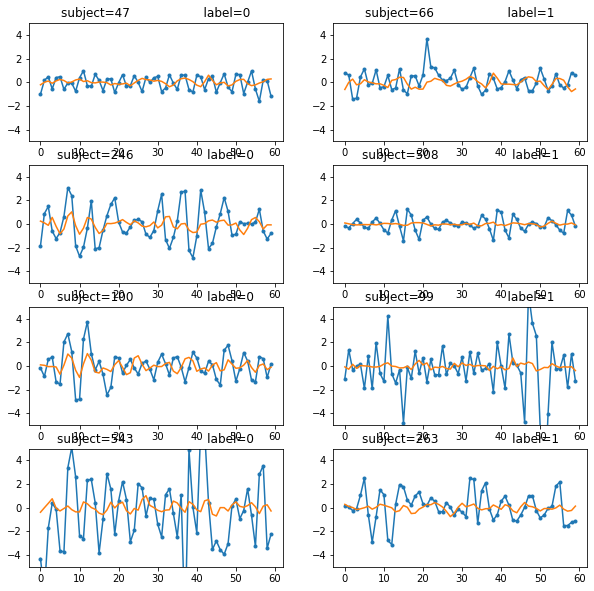

In [283]:
seqs = [0,1,6,11,14,15,19,18]
fig, axs = plt.subplots(4,2,figsize=(10,10))
axs = axs.flatten()
for idx, seq in enumerate(seqs):
    irow = (series['sequence']==seq)
    subject = series.loc[irow,'subject'].iloc[0]
    tmp = series.loc[irow,'sensor_04'].values
    ax = axs[idx]
    ax.set_title(f"subject={subject} \
                  label={labels.loc[seq].values[0]}")
    ax.set_ylim([-5,5])
    ax.plot(tmp,'.-')
    ax.plot(subject_means.loc[subject,'sensor_04'].values)

In [296]:
tmp = series.loc[series['subject']==66,['sequence','sensor_04','step']]
tmp = tmp.merge(labels,on='sequence').set_index('sequence')

In [297]:
tmp

,sensor_04,step,state
sequence,,,
1,0.789225,0,1
1,0.613359,1,1
1,-1.417513,2,1
1,-1.344486,3,1
1,0.457159,4,1
...,...,...,...
25307,0.227450,55,1
25307,-0.187757,56,1
25307,0.395976,57,1


In [303]:
1680/60

28.0

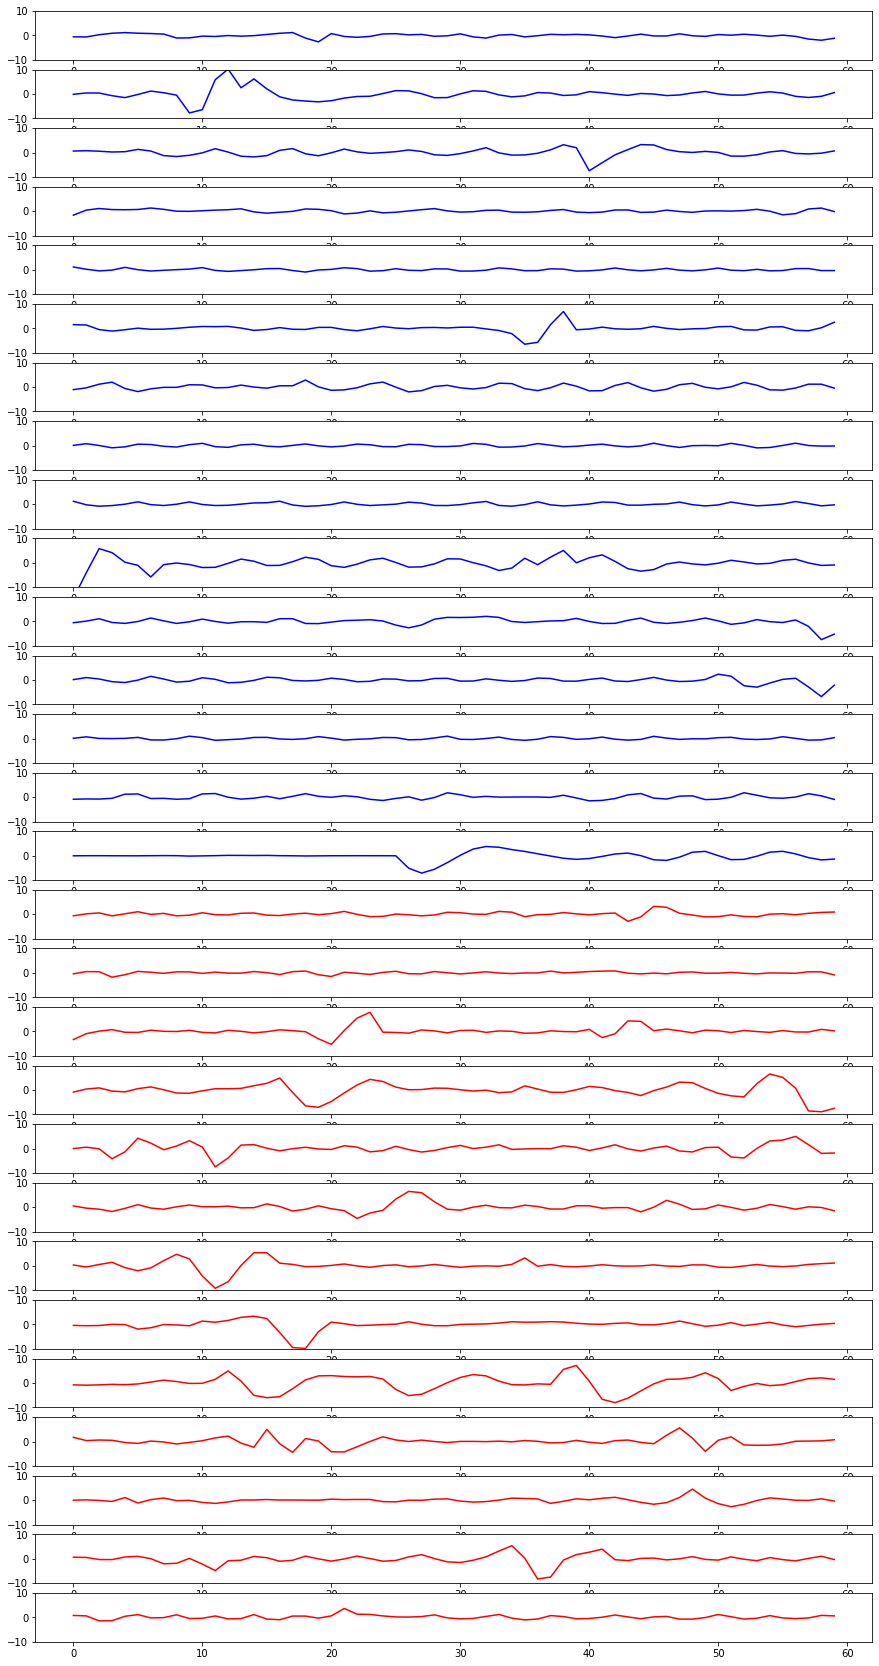

In [311]:
fig, axs = plt.subplots(28, figsize=(15,30))
iax0, iax1 = 0, 27
for iax, seq in enumerate(tmp.index.unique()):
    if tmp.loc[seq,'state'].iloc[0] == 1:
        axs[iax1].set_ylim([-10,10])
        axs[iax1].plot(tmp.loc[seq,'step'], tmp.loc[seq,'sensor_04'], 'r')  
        iax1 -= 1
    else:
        axs[iax0].set_ylim([-10,10])
        axs[iax0].plot(tmp.loc[seq,'step'], tmp.loc[seq,'sensor_04'], 'b')  
        iax0 += 1

### see template notebook, seems there is a 10sec? template?

In [312]:
train

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_12_kmean_90,sensor_12_kmean_91,sensor_12_kmean_92,sensor_12_kmean_93,sensor_12_kmean_94,sensor_12_kmean_95,sensor_12_kmean_96,sensor_12_kmean_97,sensor_12_kmean_98,sensor_12_kmean_99
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,0,0,0,0,0,0,0,0,0,0
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,0,0,0,0,0,0,0,0,0,0
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,0,0,0,0,0,0,0,0,0,0
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,0,0,0,0,0,0,0,0,0,0
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,558,0.100773,1.547826,0.193586,1.166378,-3.738022,3.974498,6.046368,0.069687,...,0,0,0,0,0,0,0,0,0,0
25964,25964,297,0.017182,1.054727,0.051777,0.646433,-5.220247,2.927357,1.030912,-1.690229,...,0,0,0,0,0,0,0,0,0,0
25965,25965,129,-0.006466,1.227428,-0.039413,0.952644,-3.422720,2.818393,-0.387944,-0.142272,...,0,0,0,0,0,0,0,0,0,0
25966,25966,170,-0.040417,0.885836,-0.051391,0.679951,-2.069552,1.710974,-2.425039,-0.259944,...,0,0,0,0,0,0,0,0,0,0


In [313]:
template_corr = pd.read_csv('template_corr.csv')

In [314]:
template_corr

,corr
0,0.166180
1,0.400776
2,0.340781
3,0.178768
4,0.177860
...,...
25963,0.186671
25964,0.269525
25965,0.583790
25966,0.437540


In [315]:
train['corr'] = template_corr['corr'].copy()

In [316]:
train

,sequence,subject,sensor_00_mean,sensor_00_std,sensor_00_median,sensor_00_mad,sensor_00_min,sensor_00_max,sensor_00_sum,sensor_00_skew,...,sensor_12_kmean_91,sensor_12_kmean_92,sensor_12_kmean_93,sensor_12_kmean_94,sensor_12_kmean_95,sensor_12_kmean_96,sensor_12_kmean_97,sensor_12_kmean_98,sensor_12_kmean_99,corr
0,0,47,0.041744,1.431660,-0.148764,0.829612,-5.634467,7.534003,2.504637,1.488052,...,0,0,0,0,0,0,0,0,0,0.166180
1,1,66,-0.069294,1.593907,-0.031298,0.964271,-6.657651,5.870943,-4.157651,-0.683454,...,0,0,0,0,0,0,0,0,0,0.400776
2,2,66,-0.001546,1.147526,0.058733,0.855307,-2.797527,3.402628,-0.092736,0.122688,...,0,0,0,0,0,0,0,0,0,0.340781
3,3,542,0.029869,1.769705,-0.119784,1.379164,-3.643740,4.856260,1.792117,0.306005,...,0,0,0,0,0,0,0,0,0,0.178768
4,4,437,0.059132,2.014779,0.005410,1.495183,-5.331530,5.455951,3.547913,-0.216130,...,0,0,0,0,0,0,0,0,0,0.177860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,25963,558,0.100773,1.547826,0.193586,1.166378,-3.738022,3.974498,6.046368,0.069687,...,0,0,0,0,0,0,0,0,0,0.186671
25964,25964,297,0.017182,1.054727,0.051777,0.646433,-5.220247,2.927357,1.030912,-1.690229,...,0,0,0,0,0,0,0,0,0,0.269525
25965,25965,129,-0.006466,1.227428,-0.039413,0.952644,-3.422720,2.818393,-0.387944,-0.142272,...,0,0,0,0,0,0,0,0,0,0.583790
25966,25966,170,-0.040417,0.885836,-0.051391,0.679951,-2.069552,1.710974,-2.425039,-0.259944,...,0,0,0,0,0,0,0,0,0,0.437540


In [317]:
X, y = train.drop(columns=['sequence','subject','label']).values, train['label'].values

In [318]:
best_param_booster, dum_clf = gridsearch_xgboost(params, X, y)

param_fit: {'eval_metric': 'auc', 'early_stopping_rounds': 50}
param_booster: {'gamma': 0, 'max_depth': 6, 'min_child_weight': 0.0, 'n_estimators': 10000, 'learning_rate': 0.3}
[0]	validation_0-auc:0.82597
[1]	validation_0-auc:0.84214
[2]	validation_0-auc:0.85396
[3]	validation_0-auc:0.86350
[4]	validation_0-auc:0.86926
[5]	validation_0-auc:0.87536
[6]	validation_0-auc:0.88182
[7]	validation_0-auc:0.88569
[8]	validation_0-auc:0.89220
[9]	validation_0-auc:0.89748
[10]	validation_0-auc:0.90076
[11]	validation_0-auc:0.90266
[12]	validation_0-auc:0.90394
[13]	validation_0-auc:0.90802
[14]	validation_0-auc:0.90932
[15]	validation_0-auc:0.91138
[16]	validation_0-auc:0.91384
[17]	validation_0-auc:0.91387
[18]	validation_0-auc:0.91522
[19]	validation_0-auc:0.91639
[20]	validation_0-auc:0.91842
[21]	validation_0-auc:0.91907
[22]	validation_0-auc:0.91988
[23]	validation_0-auc:0.92080
[24]	validation_0-auc:0.92242
[25]	validation_0-auc:0.92313
[26]	validation_0-auc:0.92326
[27]	validation_0-auc:0

[263]	validation_0-auc:0.94519
[264]	validation_0-auc:0.94508
[265]	validation_0-auc:0.94516
[266]	validation_0-auc:0.94513
[267]	validation_0-auc:0.94525
[268]	validation_0-auc:0.94526
[269]	validation_0-auc:0.94517
[270]	validation_0-auc:0.94524
[271]	validation_0-auc:0.94534
[272]	validation_0-auc:0.94545
[273]	validation_0-auc:0.94537
[274]	validation_0-auc:0.94542
[275]	validation_0-auc:0.94540
[276]	validation_0-auc:0.94529
[277]	validation_0-auc:0.94538
[278]	validation_0-auc:0.94540
[279]	validation_0-auc:0.94544
[280]	validation_0-auc:0.94538
[281]	validation_0-auc:0.94549
[282]	validation_0-auc:0.94555
[283]	validation_0-auc:0.94564
[284]	validation_0-auc:0.94572
[285]	validation_0-auc:0.94568
[286]	validation_0-auc:0.94574
[287]	validation_0-auc:0.94580
[288]	validation_0-auc:0.94588
[289]	validation_0-auc:0.94589
[290]	validation_0-auc:0.94590
[291]	validation_0-auc:0.94593
[292]	validation_0-auc:0.94583
[293]	validation_0-auc:0.94595
[294]	validation_0-auc:0.94590
[295]	va

[528]	validation_0-auc:0.94918
[529]	validation_0-auc:0.94919
[530]	validation_0-auc:0.94922
[531]	validation_0-auc:0.94923
[532]	validation_0-auc:0.94924
[533]	validation_0-auc:0.94920
[534]	validation_0-auc:0.94916
[535]	validation_0-auc:0.94919
[536]	validation_0-auc:0.94913
[537]	validation_0-auc:0.94919
[538]	validation_0-auc:0.94927
[539]	validation_0-auc:0.94922
[540]	validation_0-auc:0.94918
[541]	validation_0-auc:0.94920
[542]	validation_0-auc:0.94919
[543]	validation_0-auc:0.94921
[544]	validation_0-auc:0.94918
[545]	validation_0-auc:0.94918
[546]	validation_0-auc:0.94921
[547]	validation_0-auc:0.94927
[548]	validation_0-auc:0.94930
[549]	validation_0-auc:0.94930
[550]	validation_0-auc:0.94935
[551]	validation_0-auc:0.94939
[552]	validation_0-auc:0.94937
[553]	validation_0-auc:0.94942
[554]	validation_0-auc:0.94940
[555]	validation_0-auc:0.94937
[556]	validation_0-auc:0.94941
[557]	validation_0-auc:0.94946
[558]	validation_0-auc:0.94949
[559]	validation_0-auc:0.94951
[560]	va

[17]	validation_0-auc:0.91881
[18]	validation_0-auc:0.91927
[19]	validation_0-auc:0.92122
[20]	validation_0-auc:0.92212
[21]	validation_0-auc:0.92362
[22]	validation_0-auc:0.92543
[23]	validation_0-auc:0.92620
[24]	validation_0-auc:0.92617
[25]	validation_0-auc:0.92736
[26]	validation_0-auc:0.92912
[27]	validation_0-auc:0.92910
[28]	validation_0-auc:0.93002
[29]	validation_0-auc:0.93010
[30]	validation_0-auc:0.93142
[31]	validation_0-auc:0.93217
[32]	validation_0-auc:0.93256
[33]	validation_0-auc:0.93265
[34]	validation_0-auc:0.93342
[35]	validation_0-auc:0.93344
[36]	validation_0-auc:0.93336
[37]	validation_0-auc:0.93388
[38]	validation_0-auc:0.93431
[39]	validation_0-auc:0.93493
[40]	validation_0-auc:0.93509
[41]	validation_0-auc:0.93536
[42]	validation_0-auc:0.93585
[43]	validation_0-auc:0.93604
[44]	validation_0-auc:0.93649
[45]	validation_0-auc:0.93674
[46]	validation_0-auc:0.93674
[47]	validation_0-auc:0.93753
[48]	validation_0-auc:0.93749
[49]	validation_0-auc:0.93824
[50]	valid

[81]	validation_0-auc:0.94378
[82]	validation_0-auc:0.94368
[83]	validation_0-auc:0.94351
[84]	validation_0-auc:0.94347
[85]	validation_0-auc:0.94342
[86]	validation_0-auc:0.94368
[87]	validation_0-auc:0.94428
[88]	validation_0-auc:0.94444
[89]	validation_0-auc:0.94432
[90]	validation_0-auc:0.94413
[91]	validation_0-auc:0.94433
[92]	validation_0-auc:0.94447
[93]	validation_0-auc:0.94463
[94]	validation_0-auc:0.94467
[95]	validation_0-auc:0.94468
[96]	validation_0-auc:0.94494
[97]	validation_0-auc:0.94514
[98]	validation_0-auc:0.94528
[99]	validation_0-auc:0.94537
[100]	validation_0-auc:0.94542
[101]	validation_0-auc:0.94545
[102]	validation_0-auc:0.94522
[103]	validation_0-auc:0.94525
[104]	validation_0-auc:0.94545
[105]	validation_0-auc:0.94552
[106]	validation_0-auc:0.94535
[107]	validation_0-auc:0.94577
[108]	validation_0-auc:0.94610
[109]	validation_0-auc:0.94573
[110]	validation_0-auc:0.94595
[111]	validation_0-auc:0.94607
[112]	validation_0-auc:0.94595
[113]	validation_0-auc:0.94

[346]	validation_0-auc:0.95197
[347]	validation_0-auc:0.95201
[348]	validation_0-auc:0.95203
[349]	validation_0-auc:0.95197
[350]	validation_0-auc:0.95198
[351]	validation_0-auc:0.95196
[352]	validation_0-auc:0.95194
[353]	validation_0-auc:0.95192
[354]	validation_0-auc:0.95199
[355]	validation_0-auc:0.95201
[356]	validation_0-auc:0.95206
[357]	validation_0-auc:0.95210
[358]	validation_0-auc:0.95213
[359]	validation_0-auc:0.95214
[360]	validation_0-auc:0.95221
[361]	validation_0-auc:0.95219
[362]	validation_0-auc:0.95213
[363]	validation_0-auc:0.95210
[364]	validation_0-auc:0.95205
[365]	validation_0-auc:0.95213
[366]	validation_0-auc:0.95219
[367]	validation_0-auc:0.95228
[368]	validation_0-auc:0.95221
[369]	validation_0-auc:0.95218
[370]	validation_0-auc:0.95217
[371]	validation_0-auc:0.95229
[372]	validation_0-auc:0.95229
[373]	validation_0-auc:0.95239
[374]	validation_0-auc:0.95236
[375]	validation_0-auc:0.95249
[376]	validation_0-auc:0.95251
[377]	validation_0-auc:0.95255
[378]	va

[611]	validation_0-auc:0.95367
[612]	validation_0-auc:0.95369
[613]	validation_0-auc:0.95375
[614]	validation_0-auc:0.95378
[615]	validation_0-auc:0.95381
[616]	validation_0-auc:0.95380
[617]	validation_0-auc:0.95383
[618]	validation_0-auc:0.95384
[619]	validation_0-auc:0.95380
[620]	validation_0-auc:0.95379
[621]	validation_0-auc:0.95383
[622]	validation_0-auc:0.95389
[623]	validation_0-auc:0.95388
[624]	validation_0-auc:0.95390
[625]	validation_0-auc:0.95392
[626]	validation_0-auc:0.95394
[627]	validation_0-auc:0.95396
[628]	validation_0-auc:0.95392
[629]	validation_0-auc:0.95393
[630]	validation_0-auc:0.95395
[631]	validation_0-auc:0.95392
[632]	validation_0-auc:0.95392
[633]	validation_0-auc:0.95386
[634]	validation_0-auc:0.95383
[635]	validation_0-auc:0.95384
[636]	validation_0-auc:0.95385
[637]	validation_0-auc:0.95385
[638]	validation_0-auc:0.95392
[639]	validation_0-auc:0.95392
[640]	validation_0-auc:0.95395
[641]	validation_0-auc:0.95395
[642]	validation_0-auc:0.95398
[643]	va

[46]	validation_0-auc:0.93212
[47]	validation_0-auc:0.93193
[48]	validation_0-auc:0.93210
[49]	validation_0-auc:0.93199
[50]	validation_0-auc:0.93185
[51]	validation_0-auc:0.93252
[52]	validation_0-auc:0.93262
[53]	validation_0-auc:0.93273
[54]	validation_0-auc:0.93308
[55]	validation_0-auc:0.93411
[56]	validation_0-auc:0.93385
[57]	validation_0-auc:0.93448
[58]	validation_0-auc:0.93469
[59]	validation_0-auc:0.93463
[60]	validation_0-auc:0.93510
[61]	validation_0-auc:0.93513
[62]	validation_0-auc:0.93521
[63]	validation_0-auc:0.93554
[64]	validation_0-auc:0.93547
[65]	validation_0-auc:0.93511
[66]	validation_0-auc:0.93509
[67]	validation_0-auc:0.93518
[68]	validation_0-auc:0.93539
[69]	validation_0-auc:0.93566
[70]	validation_0-auc:0.93580
[71]	validation_0-auc:0.93578
[72]	validation_0-auc:0.93570
[73]	validation_0-auc:0.93566
[74]	validation_0-auc:0.93556
[75]	validation_0-auc:0.93552
[76]	validation_0-auc:0.93549
[77]	validation_0-auc:0.93555
[78]	validation_0-auc:0.93562
[79]	valid

[313]	validation_0-auc:0.94622
[314]	validation_0-auc:0.94620
[315]	validation_0-auc:0.94619
[316]	validation_0-auc:0.94615
[317]	validation_0-auc:0.94621
[318]	validation_0-auc:0.94631
[319]	validation_0-auc:0.94641
[320]	validation_0-auc:0.94646
[321]	validation_0-auc:0.94649
[322]	validation_0-auc:0.94659
[323]	validation_0-auc:0.94666
[324]	validation_0-auc:0.94656
[325]	validation_0-auc:0.94650
[326]	validation_0-auc:0.94659
[327]	validation_0-auc:0.94667
[328]	validation_0-auc:0.94669
[329]	validation_0-auc:0.94667
[330]	validation_0-auc:0.94671
[331]	validation_0-auc:0.94684
[332]	validation_0-auc:0.94682
[333]	validation_0-auc:0.94690
[334]	validation_0-auc:0.94694
[335]	validation_0-auc:0.94699
[336]	validation_0-auc:0.94708
[337]	validation_0-auc:0.94714
[338]	validation_0-auc:0.94721
[339]	validation_0-auc:0.94721
[340]	validation_0-auc:0.94715
[341]	validation_0-auc:0.94719
[342]	validation_0-auc:0.94720
[343]	validation_0-auc:0.94730
[344]	validation_0-auc:0.94720
[345]	va

[578]	validation_0-auc:0.95012
[579]	validation_0-auc:0.95012
[580]	validation_0-auc:0.95011
[581]	validation_0-auc:0.95015
[582]	validation_0-auc:0.95017
[583]	validation_0-auc:0.95018
[584]	validation_0-auc:0.95027
[585]	validation_0-auc:0.95024
[586]	validation_0-auc:0.95027
[587]	validation_0-auc:0.95023
[588]	validation_0-auc:0.95023
[589]	validation_0-auc:0.95021
[590]	validation_0-auc:0.95025
[591]	validation_0-auc:0.95019
[592]	validation_0-auc:0.95018
[593]	validation_0-auc:0.95023
[594]	validation_0-auc:0.95024
[595]	validation_0-auc:0.95029
[596]	validation_0-auc:0.95030
[597]	validation_0-auc:0.95028
[598]	validation_0-auc:0.95027
[599]	validation_0-auc:0.95032
[600]	validation_0-auc:0.95031
[601]	validation_0-auc:0.95030
[602]	validation_0-auc:0.95031
[603]	validation_0-auc:0.95032
[604]	validation_0-auc:0.95029
[605]	validation_0-auc:0.95026
[606]	validation_0-auc:0.95026
[607]	validation_0-auc:0.95029
[608]	validation_0-auc:0.95031
[609]	validation_0-auc:0.95039
[610]	va

[843]	validation_0-auc:0.95150
[844]	validation_0-auc:0.95148
[845]	validation_0-auc:0.95153
[846]	validation_0-auc:0.95155
[847]	validation_0-auc:0.95156
[848]	validation_0-auc:0.95154
[849]	validation_0-auc:0.95156
[850]	validation_0-auc:0.95155
[851]	validation_0-auc:0.95155
[852]	validation_0-auc:0.95154
[853]	validation_0-auc:0.95154
[854]	validation_0-auc:0.95151
[855]	validation_0-auc:0.95152
[856]	validation_0-auc:0.95152
[857]	validation_0-auc:0.95156
[858]	validation_0-auc:0.95155
[859]	validation_0-auc:0.95156
[860]	validation_0-auc:0.95152
[861]	validation_0-auc:0.95152
[862]	validation_0-auc:0.95154
[863]	validation_0-auc:0.95158
[864]	validation_0-auc:0.95154
[865]	validation_0-auc:0.95154
[866]	validation_0-auc:0.95157
[867]	validation_0-auc:0.95156
[868]	validation_0-auc:0.95156
[869]	validation_0-auc:0.95154
[870]	validation_0-auc:0.95154
[871]	validation_0-auc:0.95154
[872]	validation_0-auc:0.95157
[873]	validation_0-auc:0.95156
[874]	validation_0-auc:0.95157
[875]	va

[122]	validation_0-auc:0.93832
[123]	validation_0-auc:0.93842
[124]	validation_0-auc:0.93861
[125]	validation_0-auc:0.93862
[126]	validation_0-auc:0.93860
[127]	validation_0-auc:0.93858
[128]	validation_0-auc:0.93850
[129]	validation_0-auc:0.93846
[130]	validation_0-auc:0.93874
[131]	validation_0-auc:0.93850
[132]	validation_0-auc:0.93865
[133]	validation_0-auc:0.93866
[134]	validation_0-auc:0.93861
[135]	validation_0-auc:0.93879
[136]	validation_0-auc:0.93878
[137]	validation_0-auc:0.93869
[138]	validation_0-auc:0.93879
[139]	validation_0-auc:0.93875
[140]	validation_0-auc:0.93856
[141]	validation_0-auc:0.93903
[142]	validation_0-auc:0.93907
[143]	validation_0-auc:0.93909
[144]	validation_0-auc:0.93902
[145]	validation_0-auc:0.93907
[146]	validation_0-auc:0.93919
[147]	validation_0-auc:0.93932
[148]	validation_0-auc:0.93930
[149]	validation_0-auc:0.93935
[150]	validation_0-auc:0.93942
[151]	validation_0-auc:0.93920
[152]	validation_0-auc:0.93911
[153]	validation_0-auc:0.93941
[154]	va

In [320]:
shap_values = shap.TreeExplainer(dum_clf).shap_values(shap.sample(X,5000))

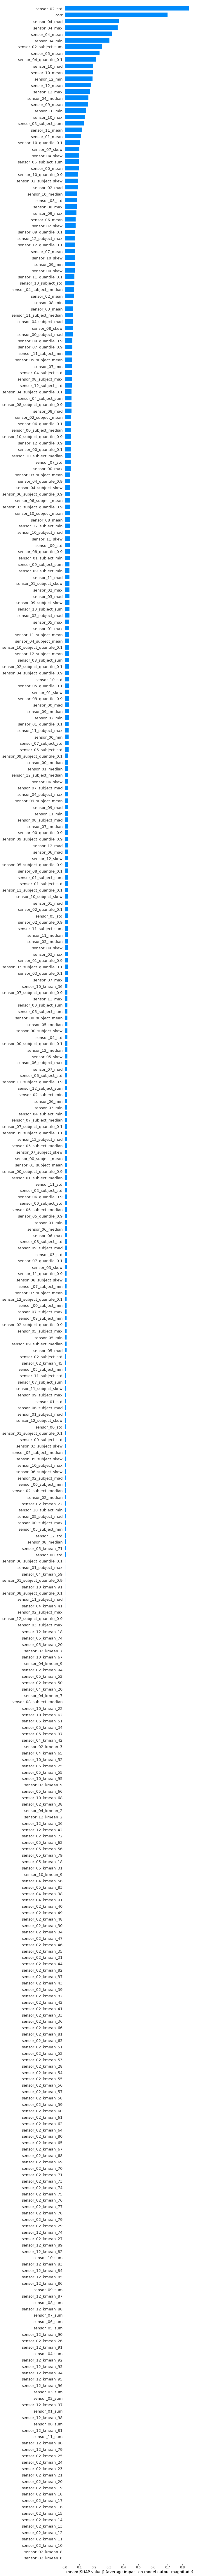

In [323]:
shap.summary_plot(shap_values, plot_type='bar', \
                  features=train.drop(columns=['sequence','subject','label']).columns, \
                  max_display=400)

### looks like Kmean is useless, but corr is quite effective

In [324]:
series.columns

Index(['sequence', 'subject', 'step', 'sensor_00', 'sensor_01', 'sensor_02',
       'sensor_03', 'sensor_04', 'sensor_05', 'sensor_06', 'sensor_07',
       'sensor_08', 'sensor_09', 'sensor_10', 'sensor_11', 'sensor_12'],
      dtype='object')